#Installing necessary modules to work with:

In [105]:
!pip install cmapPy

In [107]:
!pip install gseapy

     |████████████████████████████████| 532kB 47.7MB/s 
     |████████████████████████████████| 215kB 57.3MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 153kB 50.9MB/s 
  Created wheel for bioservices: filename=bioservices-1.7.3-cp36-none-any.whl size=221765 sha256=4dc12b16c37ab96e817e3a9897b257d2b543065a83bb97adff9bc0f4092fbf4f
  Stored in directory: /root/.cache/pip/wheels/ec/38/ae/bb146d7c3ccf420d027b2c9f38e84d8e07d75a4ff88c84002a
  Created wheel for easydev: filename=easydev-0.9.38-cp36-none-any.whl size=72215 sha256=6c2345e71560251a81bc1650e72d229ecf61392d3a30e02287d6017daad683d9
  Stored in directory: /root/.cache/pip/wheels/38/93/b7/c4ee5cf6eb4011f7db6467465fe2fb280bbb224a61400bd8a6
  Created wheel for suds-jurko: filename=suds_jurko-0.6-cp36-none-any.whl size=454638 sha256=e8f86f9550e006e6361862a3db802068166f6fc4532bf3e4baac05a5473b6d19
  Stored in directory: /root/.cache/pip/wheels/12/68/53/d3902c054e32115da1d45bac442a547a0

In [106]:
!pip install GSVA

#Importing Necessary Packages:

In [0]:
import pkg_resources
from cmapPy.pandasGEXpress.parse import parse
from cmapPy.pandasGEXpress.write_gct import write
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import plotly.offline as offline
from mpl_toolkits.mplot3d import Axes3D
from GSVA import gsva, gmt_to_dataframe
from plotnine import *
from sklearn.manifold import TSNE

In [39]:
# Print version of cmapPy being used in current conda environment 
pkg_resources.get_distribution("cmapPy").version

'4.0.1'

In [0]:
Data = parse('/content/drive/My Drive/PAAD.gct')

In [0]:
row_meta = Data.row_metadata_df
col_meta = Data.col_metadata_df
data = Data.data_df

In [42]:
row_meta.head()

rhd
rid
SLC35E2
A1BG
A1CF
A2BP1
A2LD1


In [43]:
row_meta.shape

(18465, 0)

In [44]:
col_meta.head()

chd,participant_id,sample_type,mRNAseq_cluster,bcr_patient_barcode,bcr_patient_uuid,vital_status,days_to_death,days_to_last_followup,additional_studies,adenocarcinoma_invasion,age_at_initial_pathologic_diagnosis,alcohol_history_documented,alcoholic_exposure_category,amount_of_alcohol_consumption_per_day,anatomic_neoplasm_subdivision,anatomic_neoplasm_subdivision_other,b_symptoms,bcr,bcr_aliquot_uuid,bcr_canonical_reason-2,bcr_canonical_reason-3,bcr_canonical_reason,bcr_followup_barcode,bcr_followup_uuid,bcr_patient_canonical_status,clinical_m,clinical_n,clinical_stage,clinical_t,course_number,day_of_dcc_upload,day_of_form_completion,days_to_birth,days_to_diabetes_onset,days_to_index,days_to_initial_pathologic_diagnosis,days_to_pancreatitis_onset,days_to_psa,disease_code,drugs,...,person_neoplasm_cancer_status,prescribed_dose,prescribed_dose_units,primary_lymph_node_presentation_assessment,primary_pattern,primary_therapy_outcome_success,progression_determined_by-3,project_code,psa_value,race,radiation_therapy,radiation_type_notes,radiations,regimen_number,relative_cancer_type-2,relative_cancer_type,residual_tumor,route_of_administration,secondary_pattern,serum_markers,source_of_patient_death_reason,stopped_smoking_year,surgery_performed_type,system_version,targeted_molecular_therapy,tertiary_pattern,therapy_type_notes,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site,tobacco_smoking_history,total_dose,total_dose_units,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,year_of_form_completion,year_of_initial_pathologic_diagnosis,year_of_tobacco_smoking_onset
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aab1-Primary solid Tumor,aab1,Primary solid Tumor,1.0,tcga-2j-aab1,75119d1a-93e5-4ae7-9d60-69ee929a0772,dead,66.0,NaN,NaN,yes,65,yes,weekly drinker,1.0,head of pancreas,NaN,NaN,nationwide children's hospital,d3f960b2-c69d-4b64-a30f-72f4fa7bb2f9,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-23962,NaN,0.0,0.0,NaN,NaN,paad,NaN,...,tumor free,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,1988.0,whipple,7,yes,NaN,NaN,no,yes,2j,3.0,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,1962.0
aab4-Primary solid Tumor,aab4,Primary solid Tumor,2.0,tcga-2j-aab4,33833131-1482-42d5-9cf5-01cade540234,alive,NaN,729.0,NaN,yes,48,no,NaN,NaN,other (please specify),body & tail of pancreas,NaN,nationwide children's hospital,9daae9d7-747e-44e0-a8f8-3c3f9e3f03f3,NaN,NaN,NaN,tcga-2j-aab4-f62444,ce0b8128-82b9-4164-808f-1b4447134f54,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-17794,NaN,0.0,0.0,-292.0,NaN,paad,NaN,...,tumor free,NaN,NaN,yes,NaN,complete remission/response,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,NaN,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,5.0,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN
aab6-Primary solid Tumor,aab6,Primary solid Tumor,3.0,tcga-2j-aab6,70797499-16e6-48cc-8ae4-1e692713dad3,dead,293.0,NaN,NaN,yes,75,no,NaN,NaN,body of pancreas,NaN,NaN,nationwide children's hospital,c850368e-6e95-4879-8245-205ddeec6fbd,NaN,NaN,NaN,NaN,NaN,canonical,NaN,NaN,NaN,NaN,NaN,21,5,-27600,NaN,0.0,0.0,NaN,NaN,paad,NaN,...,with tumor,NaN,NaN,yes,NaN,progressive disease,NaN,tcga,NaN,white,no,NaN,NaN,NaN,NaN,NaN,r0,NaN,NaN,NaN,medical record,NaN,distal pancreatectomy,7,yes,NaN,NaN,no,yes,2j,NaN,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN
aab8-Primary solid Tumor,aab8,Primary solid Tumor,1.0,tcga-2j-aab8,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,alive,NaN,80.0,NaN,yes,71,no,NaN,NaN,head of pancreas,NaN,NaN,nationwide children's hospital,5749429c-5ac9-40de-b44e-3b795520ec07,NaN,NaN,NaN,tcga-2j-aab8-f62434,daf7d897-0ed7-48ec-ae70-080dd8d7d6bd,canonical,NaN,NaN,NaN,NaN,NaN,21,16,-26028,NaN,0.0,0.0,NaN,NaN,paad,NaN,...,tumor free,NaN,NaN,yes,NaN,NaN,NaN,tcga,NaN,white,NaN,NaN,NaN,NaN,NaN,NaN,r1,NaN,NaN,NaN,NaN,NaN,whipple,7,yes,NaN,NaN,no,yes,2j,NaN,NaN,NaN,panc

In [45]:
col_meta.shape

(183, 124)

In [46]:
data.head()

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabu-Primary solid Tumor,aabv-Primary solid Tumor,aaqa-Primary solid Tumor,aaqe-Primary solid Tumor,aaqi-Primary solid Tumor,aaqj-Primary solid Tumor,aaql-Primary solid Tumor,aaqm-Primary solid Tumor,a9i5-Primary solid Tumor,a9i7-Primary solid Tumor,a9i9-Primary solid Tumor,a9ib-Primary solid Tumor,a9ic-Primary solid Tumor,a9ih-Primary solid Tumor,a9ij-Primary solid Tumor,a9il-Primary solid Tumor,a9in-Primary solid Tumor,a9io-Primary solid Tumor,a9ir-Primary solid Tumor,a9is-Primary solid Tumor,a9iu-Primary solid Tumor,a9iv-Primary solid Tumor,a9ix-Primary solid Tumor,a9iz-Primary solid Tumor,a9j0-Primary solid Tumor,...,aaup-Primary solid Tumor,aauq-Primary solid Tumor,aaur-Primary solid Tumor,aaus-Primary solid Tumor,aaut-Primary solid Tumor,aauu-Primary solid Tumor,aauv-Primary solid Tumor,aauw-Primary solid Tumor,a7w4-Primary solid Tumor,a7sx-Primary solid Tumor,a8f3-Primary solid Tumor,a9q5-Primary solid Tumor,a5n4-Primary solid Tumor,a75w-Primary solid Tumor,a5re-Primary solid Tumor,a5qy-Primary solid Tumor,aa2a-Primary solid Tumor,a7b8-Primary solid Tumor,aa9m-Primary solid Tumor,aaas-Primary solid Tumor,a8rm-Primary solid Tumor,a8ro-Primary solid Tumor,a8rp-Primary solid Tumor,a774-Primary solid Tumor,a776-Primary solid Tumor,a779-Primary solid Tumor,a77e-Primary solid Tumor,a77g-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.2,8.0,7.65,8.1,8.2,8.2,7.55,8.45,7.5,7.55,7.8,8.15,8.7,8.0,6.5,6.55,8.1,7.3,7.95,7.3,8.35,6.4,8.25,8.55,7.5,7.65,7.45,8.1,8.7,8.0,7.5,9.95,8.7,8.05,7.65,7.65,7.85,8.05,...,8.8,8.25,9.0,8.05,8.5,7.7,8.2,8.8,8.4,8.65,7.45,7.7,7.85,7.7,7.4,8.5,7.15,8.15,8.0,7.8,7.6,6.4,8.55,8.5,7.45,7.5,8.4,8.45,7.95,8.2,8.45,7.95,8.3,8.05,8.2,7.25,7.4,7.35,7.2,9.05
A1BG,6.40,5.8,6.4,5.8,6.70,6.6,6.3,6.5,5.70,6.30,6.8,5.90,5.7,6.70,5.4,5.8,6.7,6.00,7.0,5.7,6.50,7.8,10.00,7.3,6.10,7.20,6.5,7.10,6.50,9.3,9.5,9.7,8.6,8.00,8.5,6.20,9.00,6.70,5.30,5.10,...,6.8,7.20,7.5,7.80,7.4,5.9,7.7,6.3,7.1,6.00,6.30,6.7,5.20,8.1,7.2,8.1,6.20,7.40,6.6,7.6,5.3,6.3,6.90,6.9,4.70,6.5,6.7,5.20,8.00,7.6,7.10,7.10,6.7,7.00,6.9,7.10,7.3,7.90,6.0,6.90
A1CF,4.70,5.7,3.0,5.1,4.40,4.2,1.6,6.8,6.00,NaN,6.9,4.60,NaN,6.20,4.5,3.1,5.7,5.30,1.2,4.7,4.20,5.2,5.60,7.5,7.40,5.20,5.6,1.30,2.10,6.9,7.2,6.6,8.3,7.00,8.5,3.10,8.20,5.20,2.70,2.20,...,4.5,5.90,2.9,3.10,6.9,6.9,4.6,6.5,-1.2,0.90,7.00,6.0,4.20,5.4,5.3,1.1,6.20,5.80,6.7,4.9,7.2,4.4,6.40,4.8,7.00,6.4,6.0,5.30,5.60,5.4,5.40,6.40,6.5,4.40,3.3,3.60,6.2,1.20,4.9,2.00
A2BP1,-1.00,1.1,NaN,NaN,0.10,NaN,NaN,1.7,0.40,-1.50,1.6,0.70,-0.9,0.30,1.3,NaN,NaN,NaN,-0.1,1.3,NaN,NaN,NaN,0.3,1.10,1.50,NaN,1.00,-0.40,3.6,NaN,-0.8,-1.0,NaN,NaN,0.40,NaN,-1.30,NaN,NaN,...,NaN,0.40,-0.1,-1.00,3.7,1.8,-0.3,1.5,-1.2,NaN,0.00,-0.1,NaN,NaN,NaN,NaN,-0.50,-0.70,-1.2,0.1,0.7,-1.0,-0.90,NaN,6.60,0.6,0.4,-1.10,-0.70,1.0,3.50,1.30,-0.3,NaN,2.1,2.00,0.0,NaN,2.0,NaN
A2LD1,7.50,6.8,7.3,7.5,7.40,6.6,7.1,6.8,8.00,5.80,7.1,7.70,6.4,6.50,6.9,6.0,8.2,8.40,6.4,7.1,6.40,8.1,6.60,7.7,7.10,7.50,6.0,6.50,7.30,6.3,6.7,5.5,6.4,5.50,3.8,6.60,4.40,7.00,6.80,6.80,...,6.6,6.80,6.8,6.70,6.7,6.2,6.8,7.2,5.3,7.30,8.20,7.7,6.60,8.0,7.5,6.9,6.40,7.00,6.7,7.3,7.5,6.8,7.00,7.1,6.70,7.4,7.1,7.40,6.80,6.1,6.50,7.30,6.1,6.70,6.5,6.70,6.7,6.50,6.9,6.70


We have total of 18465 samples and 124 unique features per sample.

In [47]:
data.shape

(18465, 183)

#1. Data cleaning and checking the distribution of gene expression across samples

Checking the missing values in each column of column meta data.

In [48]:
col_meta.isnull().sum()

chd
participant_id                            0
sample_type                               0
mRNAseq_cluster                           5
bcr_patient_barcode                       0
bcr_patient_uuid                          0
                                       ... 
withdrawn                                 0
year_of_dcc_upload                        0
year_of_form_completion                   0
year_of_initial_pathologic_diagnosis      1
year_of_tobacco_smoking_onset           135
Length: 124, dtype: int64

In [0]:
#!pip install missingno

A very simple package to visualize the missing values present in the dataset. As we are handling a very large dataset, the plot we acquired out of "missingno" is very complex, messy and not very understandable. So let's move on. 

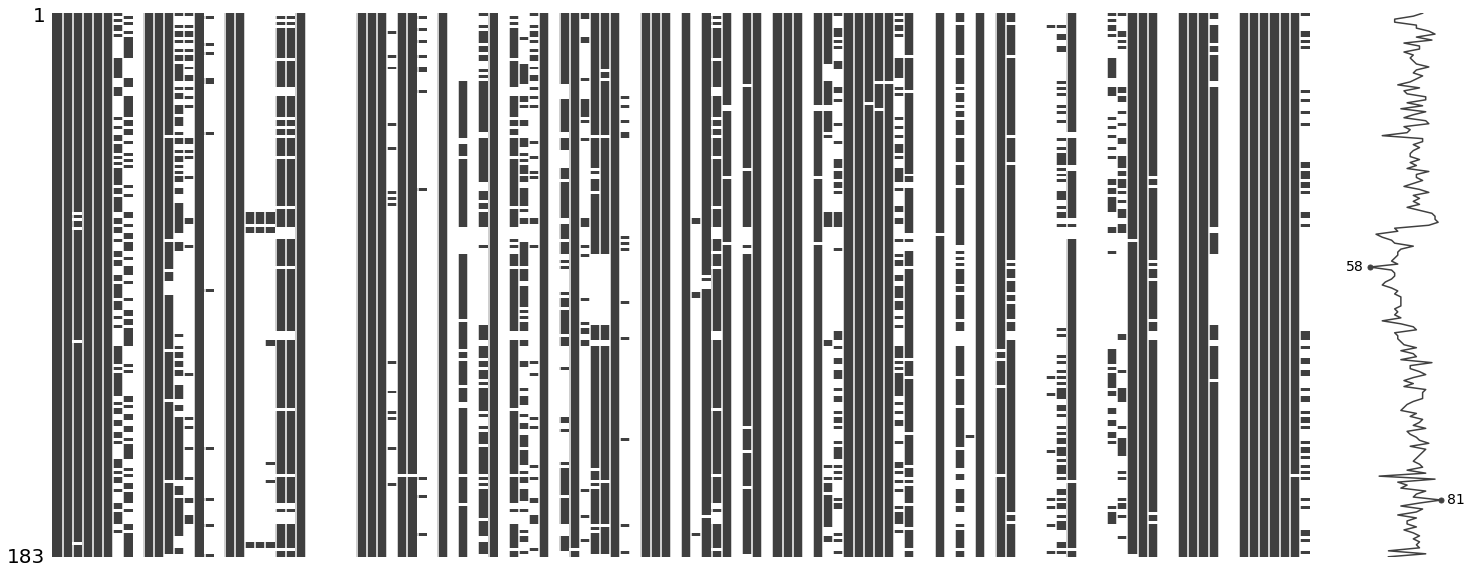

In [0]:
msno.matrix(col_meta)

Here we visualize the missing values using seaborn package, in ascending order,  after normalizing every missing value between 0 and 1. Such a plot gives us an insight about which column in column meta data has the highest percentage of missing values.

In [50]:
missing_values_col = col_meta.isnull().sum()
x = missing_values_col.to_frame()
total_missing_values_col = x[0].sum()
missing_values_col = missing_values_col / len(col_meta)
missing_values_col = missing_values_col[missing_values_col > 0]
missing_values_col.sort_values(inplace=True)
missing_values_col

chd
primary_lymph_node_presentation_assessment    0.005464
pathologic_t                                  0.005464
pathologic_n                                  0.005464
year_of_initial_pathologic_diagnosis          0.005464
histological_type                             0.005464
                                                ...   
igcccg_stage                                  1.000000
b_symptoms                                    1.000000
masaoka_stage                                 1.000000
regimen_number                                1.000000
clinical_m                                    1.000000
Length: 86, dtype: float64

In [0]:
missing_values_col = missing_values_col.to_frame()

In [0]:
missing_values_col.columns = ['count']
missing_values_col.index.names = ['Features']
missing_values_col['Features'] = missing_values_col.index

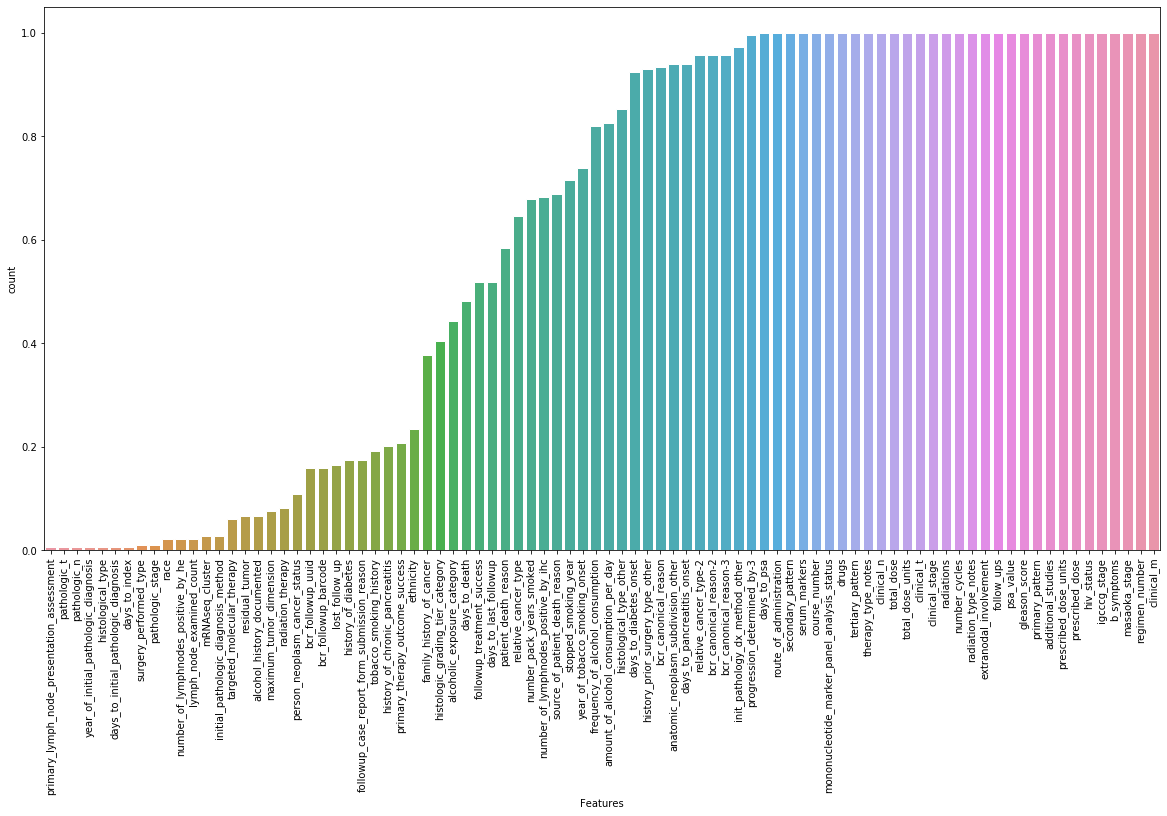

In [25]:
fig_dims = (20,10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'Features', y = 'count', data=missing_values_col, ax=ax)
plt.xticks(rotation = 90)
plt.show()


This shows us clearly that nearly 50% of the features in column meta data have 100% missing values

9659 Missing Values in all the columns of column meta data

In [53]:
total_missing_values_col

9659

We can actually remove these features as these as the data present in these features is equal or more than 50% empty

In [54]:
missing_values_col[missing_values_col['count'] >= 0.500000]

,count,Features
Features,,
followup_treatment_success,0.519126,followup_treatment_success
days_to_last_followup,0.519126,days_to_last_followup
patient_death_reason,0.584699,patient_death_reason
relative_cancer_type,0.644809,relative_cancer_type
number_pack_years_smoked,0.677596,number_pack_years_smoked
number_of_lymphnodes_positive_by_ihc,0.683060,number_of_lymphnodes_positive_by_ihc
source_of_patient_death_reason,0.688525,source_of_patient_death_reason
stopped_smoking_year,0.715847,stopped_smoking_year
year_of_tobacco_smoking_onset,0.737705,year_of_tobacco_smoking_onset


In [0]:
x = list(missing_values_col[missing_values_col['count'] >= 0.500000]['Features'])
col_meta.drop(x, axis=1, inplace=True)

In [56]:
col_meta.shape

(183, 71)

In [57]:
missing_values_col = col_meta.isnull().sum()
x = missing_values_col.to_frame()
total_missing_values_col = x[0].sum()
total_missing_values_col

734

That's a significant decrease in the missing values. The remaining missing values we can impute.

Now let's check out the missing values into each individual patient's data:

We proceed to analyse the missing values in data in a similar fashion we analyzed the missing values in column meta data. So now we check the missing values in the gene data of each individual patient record. This analysis shall give us insights about which patient record has highest percentage of missing value in their gene data.

In [58]:
missing_values = data.isnull().sum()
x = missing_values.to_frame()
total_missing_values = x[0].sum()
missing_values = missing_values / len(data)
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_values

cid
7923-Primary solid Tumor    0.015922
8637-Primary solid Tumor    0.017168
aabf-Primary solid Tumor    0.017493
8519-Primary solid Tumor    0.018197
8636-Primary solid Tumor    0.019496
                              ...   
aabv-Primary solid Tumor    0.074628
7289-Primary solid Tumor    0.083455
a7op-Primary solid Tumor    0.084972
a9is-Primary solid Tumor    0.089087
aapp-Primary solid Tumor    0.105280
Length: 183, dtype: float64

In [0]:
missing_values = missing_values.to_frame()

In [0]:
missing_values.columns = ['count']
missing_values.index.names = ['patients']
missing_values['patients'] = missing_values.index

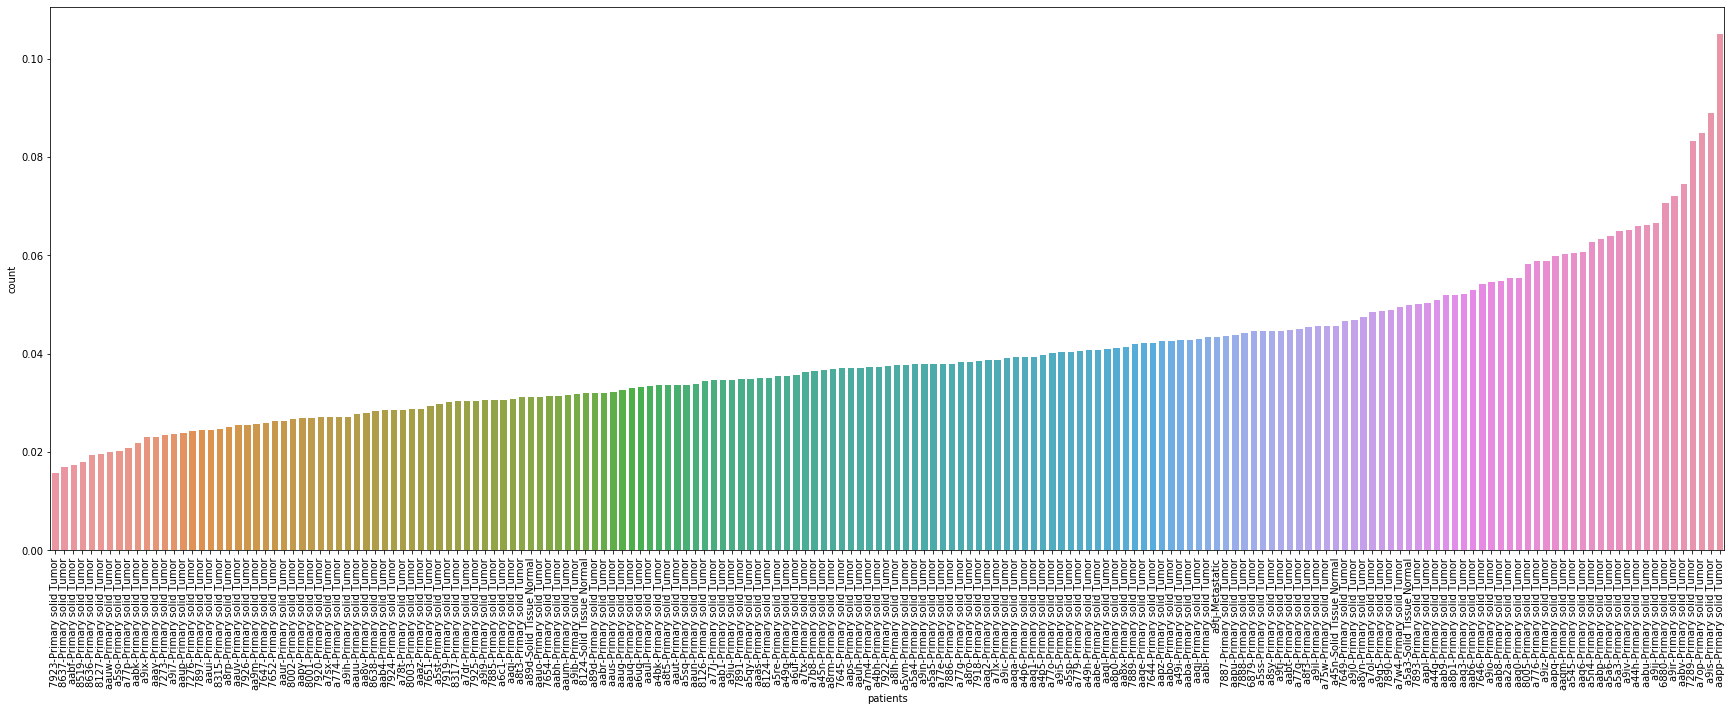

In [0]:
fig_dims = (30,10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.set(style="whitegrid", color_codes=True)
sns.barplot(x = 'patients', y = 'count', data=missing_values, ax=ax)
plt.xticks(rotation = 90)
plt.show()


The gene-data of our patients which is present towards the end of the x-axis of our plot have large amounts of missing values. Which goes out to say that we can't use those patients data for our analysis purpose

Total missing values in Patient's Gene-Data : 134954

In [61]:
total_missing_values

134954

But we cant just discard the record just because it has many missing values as medical data is very scarce thus very valuable. So we shall preserve this and try to impute the missing values to remove the missing values and retain the record for data analysis. Lets look into 5 point summary of every patient's gene-data to understand it better 

In [62]:
data.describe()

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabu-Primary solid Tumor,aabv-Primary solid Tumor,aaqa-Primary solid Tumor,aaqe-Primary solid Tumor,aaqi-Primary solid Tumor,aaqj-Primary solid Tumor,aaql-Primary solid Tumor,aaqm-Primary solid Tumor,a9i5-Primary solid Tumor,a9i7-Primary solid Tumor,a9i9-Primary solid Tumor,a9ib-Primary solid Tumor,a9ic-Primary solid Tumor,a9ih-Primary solid Tumor,a9ij-Primary solid Tumor,a9il-Primary solid Tumor,a9in-Primary solid Tumor,a9io-Primary solid Tumor,a9ir-Primary solid Tumor,a9is-Primary solid Tumor,a9iu-Primary solid Tumor,a9iv-Primary solid Tumor,a9ix-Primary solid Tumor,a9iz-Primary solid Tumor,a9j0-Primary solid Tumor,...,aaup-Primary solid Tumor,aauq-Primary solid Tumor,aaur-Primary solid Tumor,aaus-Primary solid Tumor,aaut-Primary solid Tumor,aauu-Primary solid Tumor,aauv-Primary solid Tumor,aauw-Primary solid Tumor,a7w4-Primary solid Tumor,a7sx-Primary solid Tumor,a8f3-Primary solid Tumor,a9q5-Primary solid Tumor,a5n4-Primary solid Tumor,a75w-Primary solid Tumor,a5re-Primary solid Tumor,a5qy-Primary solid Tumor,aa2a-Primary solid Tumor,a7b8-Primary solid Tumor,aa9m-Primary solid Tumor,aaas-Primary solid Tumor,a8rm-Primary solid Tumor,a8ro-Primary solid Tumor,a8rp-Primary solid Tumor,a774-Primary solid Tumor,a776-Primary solid Tumor,a779-Primary solid Tumor,a77e-Primary solid Tumor,a77g-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
count,17820.000000,17933.000000,17482.000000,17451.000000,17504.000000,17671.000000,17708.000000,18142.000000,17882.000000,17662.000000,18057.000000,17674.000000,17292.000000,17869.000000,17634.000000,17239.000000,17087.000000,17737.000000,17684.00000,17894.000000,17666.000000,17705.000000,17349.000000,17718.000000,18023.000000,17896.000000,17875.000000,17738.000000,17959.000000,17232.000000,17619.000000,17763.000000,17452.000000,17131.000000,16820.000000,17820.000000,17257.000000,18034.000000,17373.000000,17597.000000,...,18019.000000,17851.000000,17974.000000,17867.000000,17839.000000,17949.000000,17991.000000,18092.000000,17547.000000,17961.000000,17623.000000,17563.000000,17302.000000,17619.000000,17808.000000,17817.000000,17440.000000,17788.000000,17988.000000,17815.000000,17782.000000,17755.000000,17998.000000,17959.000000,17375.000000,17714.000000,17762.000000,17755.000000,17822.000000,17858.000000,17778.000000,18008.000000,17845.000000,17886.000000,17839.000000,17884.000000,17872.000000,17636.000000,17766.000000,17531.000000
mean,7.600212,7.639892,7.577106,7.728775,7.796076,7.664129,7.628627,7.698158,7.556334,7.431312,7.712920,7.736352,7.467288,7.720841,7.688663,7.676672,7.795321,7.470202,7.50703,7.645964,7.480432,7.652927,7.569872,7.647712,7.682227,7.719409,7.528210,7.599089,7.533674,7.517050,7.691650,7.812520,7.508697,7.334585,7.412343,7.496552,7.586015,7.738029,7.600925,7.545520,...,7.691537,7.772620,7.679009,7.631707,7.707331,7.550004,7.656711,7.725315,7.413793,7.584083,7.506957,7.788641,7.564080,7.566639,7.539062,7.633657,7.625093,7.675288,7.656225,7.724573,7.465333,7.539005,7.696924,7.639989,7.366786,7.512417,7.509085,7.449710,7.759779,7.779424,7.780396,7.691941,7.575872,7.685672,7.732917,7.597680,7.657147,7.540970,7.431868,7.660132
std,3.387306,3.334036,3.388864,3.184340,3.139338,3.282318,3.324786,3.290414,3.436954,3.562089,3.247335,3.204807,3.528887,3.245264,3.274954,3.217141,3.143650,3.511292,3.45827,3.340978,3.510714,3.324899,3.406347,3.326

Mean & Median analysis for each patient gene-data: 
<br>After checking most of the patients record, We can see a Negetively skewed pattern in the mean and medians of the values in the patients records.

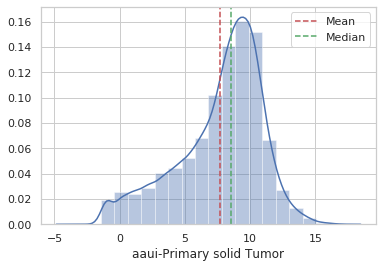

In [63]:
mean = data['aaui-Primary solid Tumor'].mean()
median = data['aaui-Primary solid Tumor'].median()

f, ax_hist = plt.subplots(1)

# sns.distplot(data['Insulin'], bins=20, ax=ax_hist)
sns.distplot(data['aaui-Primary solid Tumor'], bins=20, ax=ax_hist)

plt.axvline(mean, color='r', linestyle='--')
plt.axvline(median, color='g', linestyle='--')

plt.legend({'Mean': mean, 'Median':median})

Also checked a heat map of correlation Matrix to understand the correlation between gene-data but this plot is too messy to understand anything. So let's move forward

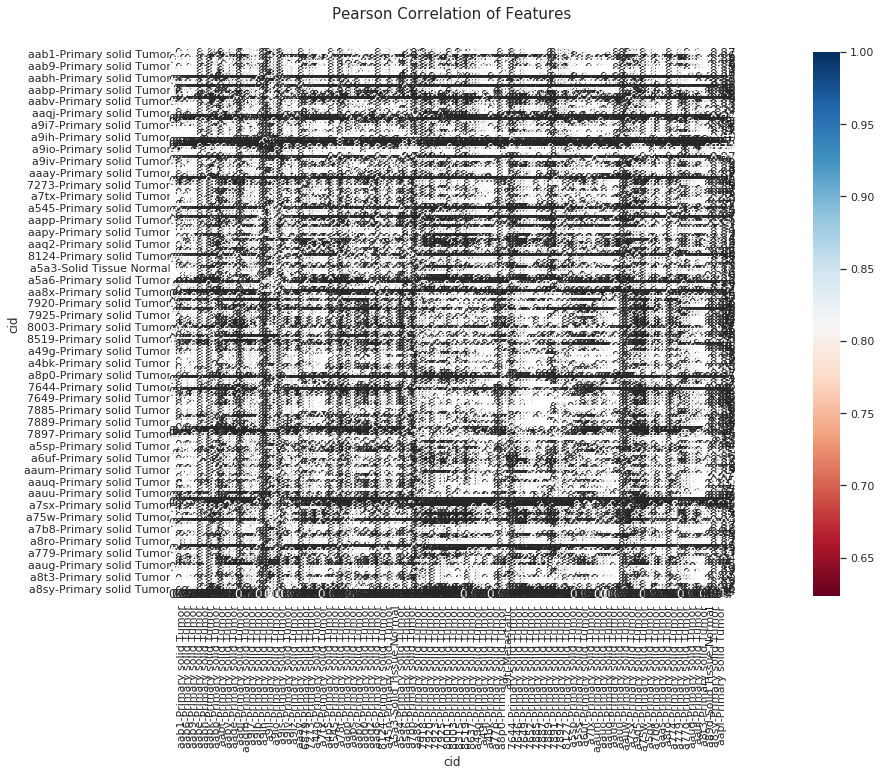

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(32,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18465 entries, SLC35E2 to psiTPTE22
Columns: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
dtypes: float32(183)
memory usage: 13.7+ MB


There are many ways one can impute the data. We shall try three methods here to impute data. The first is simple imputation which is a easy and basic imputer available in sklearn module. Its default imputation is the imputing mean, which means the missing values in the dataset will be replaced with mean of data.

Simple Imputation: Impute with simple Mean or Median values

In [0]:
# from sklearn.impute import SimpleImputer
# my_imputer = SimpleImputer()
# imputed_my_data = pd.DataFrame(my_imputer.fit_transform(data))

# # Fill in the lines below: imputation removed column names; put them back
# imputed_my_data.columns = data.columns
# imputed_my_data.index = data.index

# imputed_my_data.head()


cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabu-Primary solid Tumor,aabv-Primary solid Tumor,aaqa-Primary solid Tumor,aaqe-Primary solid Tumor,aaqi-Primary solid Tumor,aaqj-Primary solid Tumor,aaql-Primary solid Tumor,aaqm-Primary solid Tumor,a9i5-Primary solid Tumor,a9i7-Primary solid Tumor,a9i9-Primary solid Tumor,a9ib-Primary solid Tumor,a9ic-Primary solid Tumor,a9ih-Primary solid Tumor,a9ij-Primary solid Tumor,a9il-Primary solid Tumor,a9in-Primary solid Tumor,a9io-Primary solid Tumor,a9ir-Primary solid Tumor,a9is-Primary solid Tumor,a9iu-Primary solid Tumor,a9iv-Primary solid Tumor,a9ix-Primary solid Tumor,a9iz-Primary solid Tumor,a9j0-Primary solid Tumor,...,aaup-Primary solid Tumor,aauq-Primary solid Tumor,aaur-Primary solid Tumor,aaus-Primary solid Tumor,aaut-Primary solid Tumor,aauu-Primary solid Tumor,aauv-Primary solid Tumor,aauw-Primary solid Tumor,a7w4-Primary solid Tumor,a7sx-Primary solid Tumor,a8f3-Primary solid Tumor,a9q5-Primary solid Tumor,a5n4-Primary solid Tumor,a75w-Primary solid Tumor,a5re-Primary solid Tumor,a5qy-Primary solid Tumor,aa2a-Primary solid Tumor,a7b8-Primary solid Tumor,aa9m-Primary solid Tumor,aaas-Primary solid Tumor,a8rm-Primary solid Tumor,a8ro-Primary solid Tumor,a8rp-Primary solid Tumor,a774-Primary solid Tumor,a776-Primary solid Tumor,a779-Primary solid Tumor,a77e-Primary solid Tumor,a77g-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.200000,8.000000,7.65,8.100000,8.200000,8.2,7.55,8.450000,7.5,7.55,7.800000,8.15,8.7,8.000000,6.500000,6.550000,8.1,7.3,7.950000,7.300000,8.350000,6.4,8.25,8.55,7.50000,7.65,7.45,8.1,8.700000,8.0,7.5,9.950000,8.700000,8.05,7.650000,7.65,7.850000,8.050000,...,8.800000,8.25,9.0,8.05,8.5,7.7,8.2,8.8,8.4,8.650000,7.45,7.7,7.850000,7.700000,7.400000,8.500000,7.15,8.15,8.0,7.8,7.6,6.4,8.55,8.50000,7.45,7.5,8.4,8.45,7.95,8.2,8.45,7.95,8.3,8.050000,8.2,7.25,7.4,7.350000,7.2,9.050000
A1BG,6.40,5.8,6.400000,5.800000,6.70,6.600000,6.300000,6.5,5.70,6.300000,6.8,5.90,5.700000,6.70,5.4,5.800000,6.700000,6.000000,7.0,5.7,6.500000,7.800000,10.000000,7.3,6.10,7.20,6.50000,7.10,6.50,9.3,9.500000,9.7,8.6,8.000000,8.500000,6.20,9.000000,6.70,5.300000,5.100000,...,6.800000,7.20,7.5,7.80,7.4,5.9,7.7,6.3,7.1,6.000000,6.30,6.7,5.200000,8.100000,7.200000,8.100000,6.20,7.40,6.6,7.6,5.3,6.3,6.90,6.90000,4.70,6.5,6.7,5.20,8.00,7.6,7.10,7.10,6.7,7.000000,6.9,7.10,7.3,7.900000,6.0,6.900000
A1CF,4.70,5.7,3.000000,5.100000,4.40,4.200000,1.600000,6.8,6.00,7.431307,6.9,4.60,7.467205,6.20,4.5,3.100000,5.700000,5.300000,1.2,4.7,4.200000,5.200000,5.600000,7.5,7.40,5.20,5.60000,1.30,2.10,6.9,7.200000,6.6,8.3,7.000000,8.500000,3.10,8.200000,5.20,2.700000,2.200000,...,4.500000,5.90,2.9,3.10,6.9,6.9,4.6,6.5,-1.2,0.900000,7.00,6.0,4.200000,5.400000,5.300000,1.100000,6.20,5.80,6.7,4.9,7.2,4.4,6.40,4.80000,7.00,6.4,6.0,5.30,5.60,5.4,5.40,6.40,6.5,4.400000,3.3,3.60,6.2,1.200000,4.9,2.000000
A2BP1,-1.00,1.1,7.577068,7.728812,0.10,7.664174,7.628676,1.7,0.40,-1.500000,1.6,0.70,-0.900000,0.30,1.3,7.676605,7.795213,7.470156,-0.1,1.3,7.480417,7.652951,7.569822,0.3,1.10,1.50,7.52819,1.00,-0.40,3.6,7.691588,-0.8,-1.0,7.334601,7.412444,0.40,7.585991,-1.30,7.600843,7.545454,...,7.691609,0.40,-0.1,-1.00,3.7,1.8,-0.3,1.5,-1.2,7.584074,0.00,-0.1,7.564054,7.566644,7.539044,7.633615,-0.50,-0.70,-1.2,0.1,0.7,-1.0,-0

Then comes up an advanced imputation technique called K-Nearest-Neighbors imputation. KNN is an predictive algorithm which shall try to predict whether a given instance shall belong to a perticular class or not. This imputation is heavyly based on the number of neighbors initialised. 

KNN Imputation:

In [0]:
# from sklearn.impute import KNNImputer

# my_imputer = KNNImputer(n_neighbors=5)
# imputed_my_data = pd.DataFrame(my_imputer.fit_transform(data))

# # Fill in the lines below: imputation removed column names; put them back
# imputed_my_data.columns = data.columns
# imputed_my_data.index = data.index

# imputed_my_data.head()

cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabu-Primary solid Tumor,aabv-Primary solid Tumor,aaqa-Primary solid Tumor,aaqe-Primary solid Tumor,aaqi-Primary solid Tumor,aaqj-Primary solid Tumor,aaql-Primary solid Tumor,aaqm-Primary solid Tumor,a9i5-Primary solid Tumor,a9i7-Primary solid Tumor,a9i9-Primary solid Tumor,a9ib-Primary solid Tumor,a9ic-Primary solid Tumor,a9ih-Primary solid Tumor,a9ij-Primary solid Tumor,a9il-Primary solid Tumor,a9in-Primary solid Tumor,a9io-Primary solid Tumor,a9ir-Primary solid Tumor,a9is-Primary solid Tumor,a9iu-Primary solid Tumor,a9iv-Primary solid Tumor,a9ix-Primary solid Tumor,a9iz-Primary solid Tumor,a9j0-Primary solid Tumor,...,aaup-Primary solid Tumor,aauq-Primary solid Tumor,aaur-Primary solid Tumor,aaus-Primary solid Tumor,aaut-Primary solid Tumor,aauu-Primary solid Tumor,aauv-Primary solid Tumor,aauw-Primary solid Tumor,a7w4-Primary solid Tumor,a7sx-Primary solid Tumor,a8f3-Primary solid Tumor,a9q5-Primary solid Tumor,a5n4-Primary solid Tumor,a75w-Primary solid Tumor,a5re-Primary solid Tumor,a5qy-Primary solid Tumor,aa2a-Primary solid Tumor,a7b8-Primary solid Tumor,aa9m-Primary solid Tumor,aaas-Primary solid Tumor,a8rm-Primary solid Tumor,a8ro-Primary solid Tumor,a8rp-Primary solid Tumor,a774-Primary solid Tumor,a776-Primary solid Tumor,a779-Primary solid Tumor,a77e-Primary solid Tumor,a77g-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.2,8.0,7.65,8.1,8.20,8.2,7.55,8.45,7.5,7.55,7.80,8.15,8.7,8.00,6.5,6.55,8.1,7.3,7.95,7.3,8.35,6.4,8.25,8.55,7.5,7.65,7.45,8.1,8.70,8.0,7.5,9.95,8.7,8.05,7.65,7.65,7.85,8.05,...,8.80,8.25,9.0,8.05,8.5,7.7,8.2,8.8,8.4,8.65,7.45,7.7,7.85,7.70,7.4,8.50,7.15,8.15,8.0,7.8,7.6,6.4,8.55,8.5,7.45,7.5,8.4,8.45,7.95,8.2,8.45,7.95,8.3,8.05,8.2,7.25,7.4,7.35,7.2,9.05
A1BG,6.40,5.8,6.4,5.8,6.70,6.6,6.30,6.5,5.70,6.30,6.8,5.90,5.70,6.70,5.4,5.80,6.7,6.00,7.0,5.7,6.50,7.8,10.00,7.3,6.10,7.20,6.5,7.10,6.50,9.3,9.50,9.7,8.6,8.00,8.5,6.20,9.00,6.70,5.30,5.10,...,6.80,7.20,7.5,7.80,7.4,5.9,7.7,6.3,7.1,6.00,6.30,6.7,5.20,8.10,7.2,8.10,6.20,7.40,6.6,7.6,5.3,6.3,6.90,6.9,4.70,6.5,6.7,5.20,8.00,7.6,7.10,7.10,6.7,7.00,6.9,7.10,7.3,7.90,6.0,6.90
A1CF,4.70,5.7,3.0,5.1,4.40,4.2,1.60,6.8,6.00,3.36,6.9,4.60,0.96,6.20,4.5,3.10,5.7,5.30,1.2,4.7,4.20,5.2,5.60,7.5,7.40,5.20,5.6,1.30,2.10,6.9,7.20,6.6,8.3,7.00,8.5,3.10,8.20,5.20,2.70,2.20,...,4.50,5.90,2.9,3.10,6.9,6.9,4.6,6.5,-1.2,0.90,7.00,6.0,4.20,5.40,5.3,1.10,6.20,5.80,6.7,4.9,7.2,4.4,6.40,4.8,7.00,6.4,6.0,5.30,5.60,5.4,5.40,6.40,6.5,4.40,3.3,3.60,6.2,1.20,4.9,2.00
A2BP1,-1.00,1.1,0.7,0.5,0.10,0.3,-0.24,1.7,0.40,-1.50,1.6,0.70,-0.90,0.30,1.3,0.94,1.4,0.22,-0.1,1.3,-0.20,0.2,1.32,0.3,1.10,1.50,-0.2,1.00,-0.40,3.6,0.42,-0.8,-1.0,-0.30,-0.1,0.40,0.16,-1.30,-0.20,-0.50,...,-0.48,0.40,-0.1,-1.00,3.7,1.8,-0.3,1.5,-1.2,-0.64,0.00,-0.1,-0.28,-0.08,-0.9,0.54,-0.50,-0.70,-1.2,0.1,0.7,-1.0,-0.90,-0.8,6.60,0.6,0.4,-1.10,-0.70,1.0,3.50,1.30,-0.3,0.22,2.1,2.00,0.0,0.56,2.0,1.02
A2LD1,7.50,6.8,7.3,7.5,7.40,6.6,7.10,6.8,8.00,5.80,7.1,7.70,6.40,6.50,6.9,6.00,8.2,8.40,6.4,7.1,6.40,8.1,6.60,7.7,7.10,7.50,6.0,6.50,7.30,6.3,6.70,5.5,6.4,5.50,3.8,6.60,4.40,7.00,6.80,6.80,...,6.60,6.80,6.8,6.70,6.7,6.2,6.8,7.2,5.3,7.30,8.20,7.7,6.60,8.00,7.5,6.90,6.40,7.00,6.7,7.3,7.5,6.8,7.00,7.1,6.70,7.4,7.1,7.40,6.80,6.1,6.50,7.30,6.1,6.70,6.5,6.70,6.7,6.50,6.9,6.70


In [0]:
# missing_values_after_im = imputed_my_data.isnull().sum()
# x = missing_values_after_im.to_frame()
# total_missing_values_after_im = x[0].sum()
# print('Missing Values in dataset after KNN Imputation: {}'.format(total_missing_values_after_im))

The next Imputation technique is quite advanced as it uses an advanced algorithm which is similar to the MICE (**M**ultivariate **I**mputation via **C**hained **E**quations) algorithm present in R Programming language. Iterative imputer that estimates each feature from all the others.

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. This takes a while to compute given that we shall run for 10 iterations.

Iterative Imputer:

In [65]:
imputer = IterativeImputer(max_iter=10, verbose=0)
data_im = pd.DataFrame(imputer.fit_transform(data))

data_im.columns = data.columns
data_im.index = data.index

data_im.head()

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



cid,aab1-Primary solid Tumor,aab4-Primary solid Tumor,aab6-Primary solid Tumor,aab8-Primary solid Tumor,aab9-Primary solid Tumor,aaba-Primary solid Tumor,aabe-Primary solid Tumor,aabf-Primary solid Tumor,aabh-Primary solid Tumor,aabi-Primary solid Tumor,aabk-Primary solid Tumor,aabo-Primary solid Tumor,aabp-Primary solid Tumor,aabr-Primary solid Tumor,aabt-Primary solid Tumor,aabu-Primary solid Tumor,aabv-Primary solid Tumor,aaqa-Primary solid Tumor,aaqe-Primary solid Tumor,aaqi-Primary solid Tumor,aaqj-Primary solid Tumor,aaql-Primary solid Tumor,aaqm-Primary solid Tumor,a9i5-Primary solid Tumor,a9i7-Primary solid Tumor,a9i9-Primary solid Tumor,a9ib-Primary solid Tumor,a9ic-Primary solid Tumor,a9ih-Primary solid Tumor,a9ij-Primary solid Tumor,a9il-Primary solid Tumor,a9in-Primary solid Tumor,a9io-Primary solid Tumor,a9ir-Primary solid Tumor,a9is-Primary solid Tumor,a9iu-Primary solid Tumor,a9iv-Primary solid Tumor,a9ix-Primary solid Tumor,a9iz-Primary solid Tumor,a9j0-Primary solid Tumor,...,aaup-Primary solid Tumor,aauq-Primary solid Tumor,aaur-Primary solid Tumor,aaus-Primary solid Tumor,aaut-Primary solid Tumor,aauu-Primary solid Tumor,aauv-Primary solid Tumor,aauw-Primary solid Tumor,a7w4-Primary solid Tumor,a7sx-Primary solid Tumor,a8f3-Primary solid Tumor,a9q5-Primary solid Tumor,a5n4-Primary solid Tumor,a75w-Primary solid Tumor,a5re-Primary solid Tumor,a5qy-Primary solid Tumor,aa2a-Primary solid Tumor,a7b8-Primary solid Tumor,aa9m-Primary solid Tumor,aaas-Primary solid Tumor,a8rm-Primary solid Tumor,a8ro-Primary solid Tumor,a8rp-Primary solid Tumor,a774-Primary solid Tumor,a776-Primary solid Tumor,a779-Primary solid Tumor,a77e-Primary solid Tumor,a77g-Primary solid Tumor,a77j-Primary solid Tumor,aaug-Primary solid Tumor,aauh-Primary solid Tumor,aaui-Primary solid Tumor,aaul-Primary solid Tumor,a8t3-Primary solid Tumor,a8t5-Primary solid Tumor,a89d-Solid Tissue Normal,a89d-Primary solid Tumor,a8sy-Primary solid Tumor,a8lh-Primary solid Tumor,aapl-Primary solid Tumor
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SLC35E2,7.45,8.1,7.200000,8.000000,7.65,8.10000,8.200000,8.2,7.55,8.45000,7.5,7.55,7.800000,8.15,8.7,8.000000,6.500000,6.550000,8.1,7.3,7.950000,7.300000,8.350000,6.4,8.25,8.55,7.500000,7.65,7.45,8.1,8.700000,8.0,7.5,9.950000,8.700000,8.05,7.650000,7.65,7.85000,8.050000,...,8.800000,8.25,9.0,8.05,8.5,7.7,8.2,8.8,8.4,8.650000,7.45,7.7,7.850000,7.700000,7.400000,8.500000,7.15,8.15,8.0,7.8,7.6,6.4,8.55,8.500000,7.45,7.5,8.4,8.45,7.95,8.2,8.45,7.95,8.3,8.050000,8.2,7.25,7.4,7.350000,7.2,9.05000
A1BG,6.40,5.8,6.400000,5.800000,6.70,6.60000,6.300000,6.5,5.70,6.30000,6.8,5.90,5.700000,6.70,5.4,5.800000,6.700000,6.000000,7.0,5.7,6.500000,7.800000,10.000000,7.3,6.10,7.20,6.500000,7.10,6.50,9.3,9.500000,9.7,8.6,8.000000,8.500000,6.20,9.000000,6.70,5.30000,5.100000,...,6.800000,7.20,7.5,7.80,7.4,5.9,7.7,6.3,7.1,6.000000,6.30,6.7,5.200000,8.100000,7.200000,8.100000,6.20,7.40,6.6,7.6,5.3,6.3,6.90,6.900000,4.70,6.5,6.7,5.20,8.00,7.6,7.10,7.10,6.7,7.000000,6.9,7.10,7.3,7.900000,6.0,6.90000
A1CF,4.70,5.7,3.000000,5.100000,4.40,4.20000,1.600000,6.8,6.00,-0.20688,6.9,4.60,-0.388516,6.20,4.5,3.100000,5.700000,5.300000,1.2,4.7,4.200000,5.200000,5.600000,7.5,7.40,5.20,5.600000,1.30,2.10,6.9,7.200000,6.6,8.3,7.000000,8.500000,3.10,8.200000,5.20,2.70000,2.200000,...,4.500000,5.90,2.9,3.10,6.9,6.9,4.6,6.5,-1.2,0.900000,7.00,6.0,4.200000,5.400000,5.300000,1.100000,6.20,5.80,6.7,4.9,7.2,4.4,6.40,4.800000,7.00,6.4,6.0,5.30,5.60,5.4,5.40,6.40,6.5,4.400000,3.3,3.60,6.2,1.200000,4.9,2.00000
A2BP1,-1.00,1.1,-0.064388,-0.280894,0.10,-0.59452,-0.962603,1.7,0.40,-1.50000,1.6,0.70,-0.900000,0.30,1.3,0.109806,0.814124,-0.355736,-0.1,1.3,-0.805577,0.501751,0.900889,0.3,1.10,1.50,0.326869,1.00,-0.40,3.6,-0.429103,-0.8,-1.0,0.426763,-1.947529,0.40,-1.945757,-1.30,0.26241,-0.424294,...,-0.434085,0.40,-0.1,-1.00,3.7,1.8,-0.3,1.5,-1.2,0.072295,0.00,-0.1,-0.330772,0.078742,-0.077017,-0.464474,-0.50,-0.70,-1.2,0.1,0.7

Now check the missing values after imputation task

In [66]:
missing_values_after_im = data_im.isnull().sum()
x = missing_values_after_im.to_frame()
total_missing_values_after_im = x[0].sum()
total_missing_values_after_im
print('Missing Values in dataset after Iterative Imputation: {}'.format(total_missing_values_after_im))

Missing Values in dataset after Iterative Imputation: 0


Let's Look into Gene expression distribution of samples. <br> For this we need to understand the column description of column meta data. We get a clear cut idea about the data description after looking at our RNA data in "phantasus" tool.

In [67]:
# Columns of our col_meta. 
# Features of our patients data.

x = list(col_meta.columns)
x

['participant_id',
 'sample_type',
 'mRNAseq_cluster',
 'bcr_patient_barcode',
 'bcr_patient_uuid',
 'vital_status',
 'days_to_death',
 'adenocarcinoma_invasion',
 'age_at_initial_pathologic_diagnosis',
 'alcohol_history_documented',
 'alcoholic_exposure_category',
 'anatomic_neoplasm_subdivision',
 'bcr',
 'bcr_aliquot_uuid',
 'bcr_followup_barcode',
 'bcr_followup_uuid',
 'bcr_patient_canonical_status',
 'day_of_dcc_upload',
 'day_of_form_completion',
 'days_to_birth',
 'days_to_index',
 'days_to_initial_pathologic_diagnosis',
 'disease_code',
 'ethnicity',
 'family_history_of_cancer',
 'file_uuid',
 'followup_case_report_form_submission_reason',
 'gender',
 'histologic_grading_tier_category',
 'histological_type',
 'history_of_chronic_pancreatitis',
 'history_of_diabetes',
 'history_of_neoadjuvant_treatment',
 'icd_10',
 'icd_o_3_histology',
 'icd_o_3_site',
 'informed_consent_verified',
 'initial_pathologic_diagnosis_method',
 'lost_follow_up',
 'lymph_node_examined_count',
 'maxim

#Data Description:<br>
<br>
1.  participant_id -> Unique ID of our patient. 
<br>
2.  mRNAseq_cluster -> estimates of the levels of individual isoforms within the cell of RNA sequence. 
<br>
3. bcr_patient_barcode & bcr_patient_uuid ->  bar code metadata of the patients and their samples.
<br>
4. vital_status ->  Status of patient(live/death) while the data was recorded.
<br>
5. days_to_death & days_to_last_followup -> Number of days left for patients to live after being diagnosed and Number of days from patient's last follow up with the doctor.
<br>
6. adenocarcinoma_invasion -> Notifies if the cancer grows and spreads to near cell or not.
<br>
7. age_at_initial_pathologic_diagnosis -> Age of the patient when he/she was diagnosed with the disease.
<br>
8. alcohol_history_documented, alcoholic_exposure_category, amount_of_alcohol_consumption_per_day -> Alcohol history of our patients
<br>
9. maximum_tumor_dimension -> Size of Tumor, tumor size is strongly related to chances for survival.
<br>
10. ethnicity -> Race of the patient
<br>
11. gender -> Gender of the patient
<br>
12. gleason_score -> Ranges from 1-5 and describes how much the cancer from a biopsy looks like healthy tissue (lower score) or abnormal tissue (higher score). Most cancers score a grade of 3 or higher.
<br>
13. icd_10 -> ICD-10 codes are alphanumeric codes used by doctors, health insurance companies, and public health agencies across the world to represent diagnoses.
<br>
14. icd_o_3-histology -> Tumor codes
<br>
15. lymph_node_examined_count -> Number of Lymph nodes found
<br>
16. masaoka_stage ->  Masaoka-Koga Staging System consisting of 6 stages
<br>
17. maximum_tumor_dimension -> The Dimensions of the tumor
<br>
18. race -> Race of the patient
<br>
19. radiation_therapy -> Notifies if the patient has undergone radiation theorpy or not.
<br>
20. pathologic_stage -> Stage of cancer
<br>
21. pathologic_m -> The M here refers to whether the cancer has metastasized or not, i.e the cancer has spread from the primary tumor to other parts of the body or not.
<br>
22. pathologic_n -> The N here refers to the the number of nearby lymph nodes that have cancer.
<br>
23. pathologic_t -> The T here refers to the size and extent of primary tumor.
<br>
24. neoplasm histologic grade -> A description of a tumor based on how abnormal the cancer cells and tissue look under a microscope and how quickly the cancer cells are likely to grow and spread.


Let's explore Gene-expression samples for having a fine-grained understandings.

In [0]:
# Target variable: 

col_meta['sample_type'].value_counts()

Primary solid Tumor    178
Solid Tissue Normal      4
Metastatic               1
Name: sample_type, dtype: int64

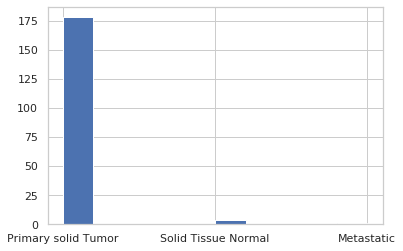

In [0]:
col_meta['sample_type'].hist()

Our Target variable is highly imbalanced. Out of 183 records we have 178 records are Tumorous data and only 4 are Normal Tissues.

Let's see what's the vital status of the patient was when the data was recorded.

In [0]:
col_meta['vital_status'].value_counts()

dead     95
alive    88
Name: vital_status, dtype: int64

So we have a collected data of 95 dead patients and 88 alive patients. This balance is good to understand the effects of the tumor in both dead and alive patients.

In [0]:
col_meta['gender'].value_counts()

male      101
female     82
Name: gender, dtype: int64

Text(0.5, 1.0, 'Vital status of patient by Gender ')

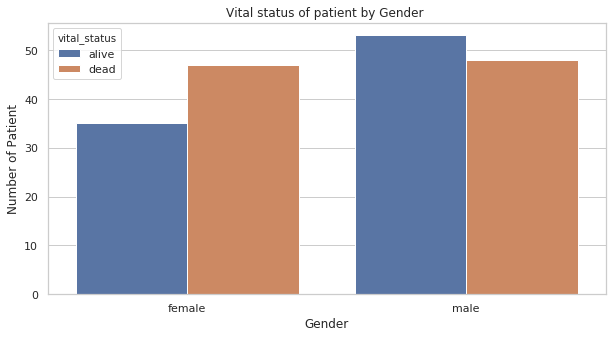

In [0]:
x = col_meta.groupby(['gender', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='gender', y='counts', hue='vital_status', data=x)
plt.ylabel('Number of Patient')
plt.xlabel('Gender')
plt.title('Vital status of patient by Gender ')

In [0]:
for i in range(0,4):
  y = x['counts'][i] / col_meta['participant_id'].count()
  if i <= 1: print("Percent of females alive: {} %".format(round(y * 100),2))
  else: print("Percent of males alive: {} %".format(round(y * 100),2))

Percent of females alive: 19.0 %
Percent of females alive: 26.0 %
Percent of males alive: 29.0 %
Percent of males alive: 26.0 %


So we can see how many male and female patients were alive and dead during the time when data was recorded.

Let's look at how many patient's were recorded dead and alive with different mRNA Sequence cluster. 

Text(0.5, 1.0, 'Vital status of patient by mRNA sequence cluster types ')

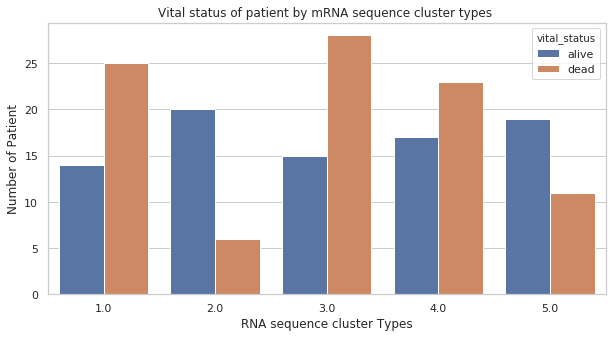

In [0]:
mRNA_seq_group = col_meta.groupby(['mRNAseq_cluster', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='mRNAseq_cluster', y='counts', hue='vital_status', data=mRNA_seq_group)
plt.ylabel('Number of Patient')
plt.xlabel('RNA sequence cluster Types')
plt.title('Vital status of patient by mRNA sequence cluster types ')

Let's check how many people were alive and dead with certain type of mRNA seq cluster

In [0]:
for i in mRNA_seq_group['mRNAseq_cluster'].unique():
  x = mRNA_seq_group[mRNA_seq_group['mRNAseq_cluster'] == i]
  y = round(x[x['vital_status'] == 'alive']['counts'] / sum(x['counts'].values),2)
  w = round(x[x['vital_status'] == 'dead']['counts'] / sum(x['counts'].values),2)

  print('{} times patients are alive with mRNAseq Cluster type {}'.format(y.values[0],i))
  print('\n')
  print('{} times patients are dead with mRNAseq Cluster type {}'.format(w.values[0],i))
  print('\n')


0.36 times patients are alive with mRNAseq Cluster type 1.0


0.64 times patients are dead with mRNAseq Cluster type 1.0


0.77 times patients are alive with mRNAseq Cluster type 2.0


0.23 times patients are dead with mRNAseq Cluster type 2.0


0.35 times patients are alive with mRNAseq Cluster type 3.0


0.65 times patients are dead with mRNAseq Cluster type 3.0


0.42 times patients are alive with mRNAseq Cluster type 4.0


0.57 times patients are dead with mRNAseq Cluster type 4.0


0.63 times patients are alive with mRNAseq Cluster type 5.0


0.37 times patients are dead with mRNAseq Cluster type 5.0




Clearly 65% of time patient are dead if the mRNAseq cluster type is 1 and 3. mRNAseq cluster 1, 3, 4 are riskier than 2,5

In [0]:
for item in enumerate(mRNA_seq_group['mRNAseq_cluster']):
  x = col_meta['participant_id'].count()
  y =  round(mRNA_seq_group['counts'][item[0]] / x, 2)
  if item[0] % 2 == 0:
    print('{} % patients are alive with mRNA_seq cluster of type {}'.format(y,item[1]))
    print('\n')
  else:
    print('{} % patients are dead with mRNA_seq cluster of type {}'.format(y,item[1]))
    print('\n')

0.08 % patients are alive with mRNA_seq cluster of type 1.0


0.14 % patients are dead with mRNA_seq cluster of type 1.0


0.11 % patients are alive with mRNA_seq cluster of type 2.0


0.03 % patients are dead with mRNA_seq cluster of type 2.0


0.08 % patients are alive with mRNA_seq cluster of type 3.0


0.15 % patients are dead with mRNA_seq cluster of type 3.0


0.09 % patients are alive with mRNA_seq cluster of type 4.0


0.13 % patients are dead with mRNA_seq cluster of type 4.0


0.1 % patients are alive with mRNA_seq cluster of type 5.0


0.06 % patients are dead with mRNA_seq cluster of type 5.0




Text(0.5, 1.0, 'Gender of patients by mRNA sequence cluster types ')

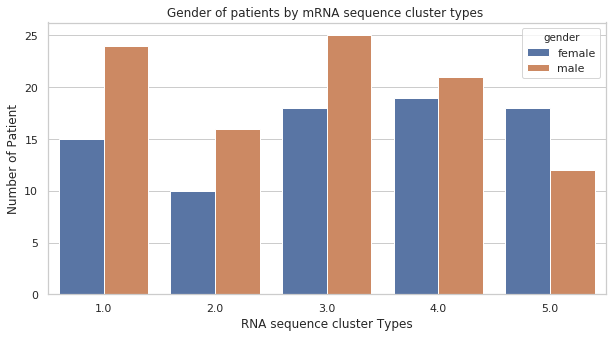

In [0]:
mRNA_seq_group = col_meta.groupby(['mRNAseq_cluster', 'gender'])['gender'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='mRNAseq_cluster', y='counts', hue='gender', data=mRNA_seq_group)
plt.ylabel('Number of Patient')
plt.xlabel('RNA sequence cluster Types')
plt.title('Gender of patients by mRNA sequence cluster types ')

We can see that males are more likely to have mRNA seq cluster of type 1,3 & 4 where as the females majorly have mRNA seq cluster of type 3,4 & 5

Text(0.5, 1.0, 'Race by mRNA sequence cluster types ')

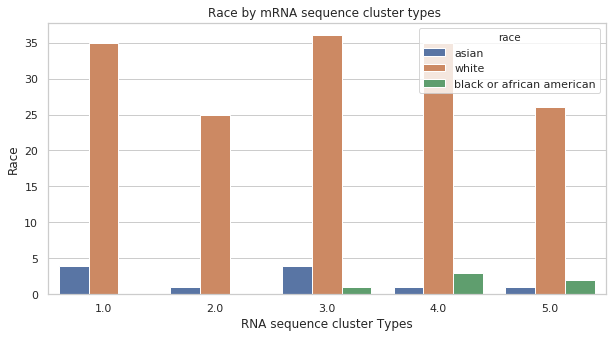

In [0]:
mRNA_seq_group = col_meta.groupby(['mRNAseq_cluster', 'race'])['race'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='mRNAseq_cluster', y='counts', hue='race', data=mRNA_seq_group)
plt.ylabel('Race')
plt.xlabel('RNA sequence cluster Types')
plt.title('Race by mRNA sequence cluster types ')

Text(0.5, 1.0, 'Vital status of patient by type of Tumor ')

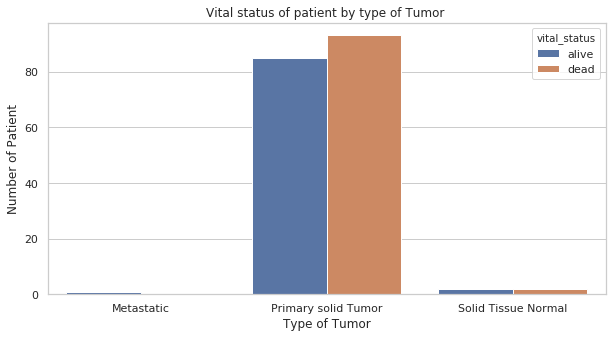

In [0]:
mRNA_seq_group = col_meta.groupby(['sample_type', 'vital_status'])['vital_status'].count().reset_index(name='counts')
plt.figure(figsize=(10, 5))
sns.barplot(x='sample_type', y='counts', hue='vital_status', data=mRNA_seq_group)
plt.ylabel('Number of Patient')
plt.xlabel('Type of Tumor')
plt.title('Vital status of patient by type of Tumor ')

As we can see the records with Primary solid tumor consists equal number of alive and dead cases.

Looking at adenocarcinoma_invasion is also important to know if the cancer did grow and has started spreading to the nearby cells

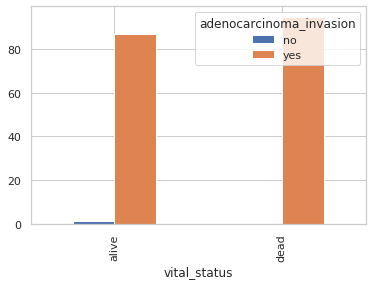

In [0]:
x = pd.crosstab(index=col_meta['vital_status'], columns=col_meta['adenocarcinoma_invasion'], dropna=True)
x.plot.bar()

As we see that the it does'nt matter if the patient is alive or not, the cancer always does grow and spreads.

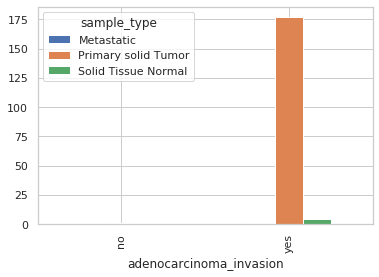

In [0]:
x = pd.crosstab(index=col_meta['adenocarcinoma_invasion'], columns=col_meta['sample_type'], dropna=True)
x.plot.bar()

Primary solid tumors are majorly endocrine (adenocarcinoma). We can also see some endocrine tumors are also normal. We don't see any metastatic tumor associated with endocrine and neuroendocrine

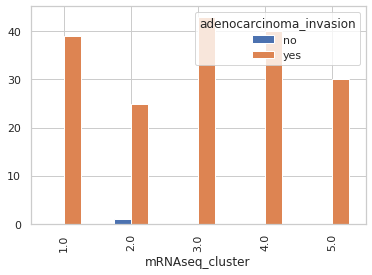

In [0]:
x = pd.crosstab(index=col_meta['mRNAseq_cluster'], columns=col_meta['adenocarcinoma_invasion'], dropna=True)
x.plot.bar()

We shall also look into the comparision of lymph nodes counted with the vital status

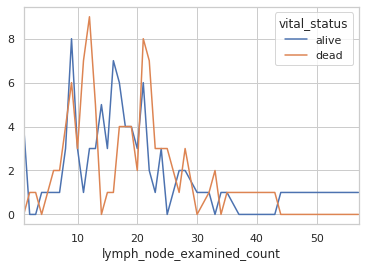

In [0]:
x = pd.crosstab(index=col_meta['lymph_node_examined_count'], columns=col_meta['vital_status'], dropna=True)
x.plot()

The above plot shows the distribution of patients alive / dead in comparision with lymph nodes counted. <br> As we can see the patients having lymph nodes count in the range of 10 to 25 are , in equal numbers, alive & dead. In this aspect we would require more data to inspect furthur.

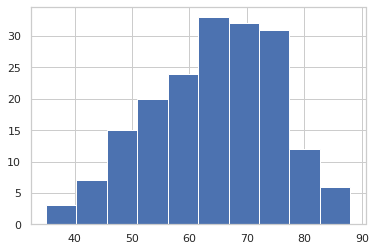

In [0]:
col_meta['age_at_initial_pathologic_diagnosis'].hist(bins=10)

We this shows that the initial age to diagnosis is in the range of 60 to 75

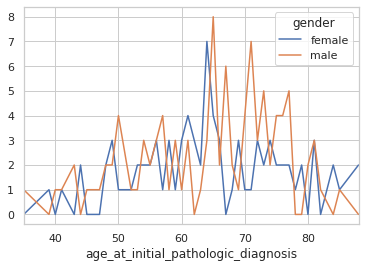

In [0]:
x = pd.crosstab(index=col_meta['age_at_initial_pathologic_diagnosis'], columns=col_meta['gender'], dropna=True)
x.plot()

This plot shows how the initial age at which the patients under went diagnosis for both male and female genders. As we can see the most female patients are in the age range of 60 - 70 and for male patients, the age range is 60 - 80

Now let's check out the Maximum tumor size and it's associations to the tumor

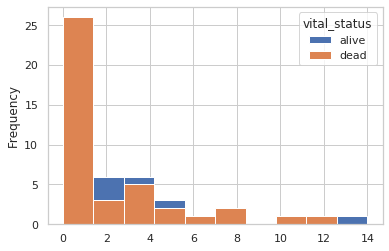

In [0]:
x = pd.crosstab(index=col_meta['maximum_tumor_dimension'], columns=col_meta['vital_status'], dropna=True)
x.plot.hist()

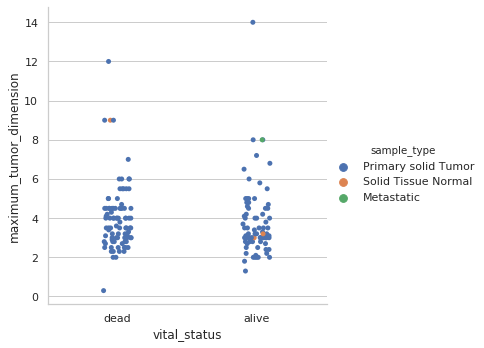

In [0]:
sns.catplot(x='vital_status', y='maximum_tumor_dimension', hue='sample_type', data=col_meta)

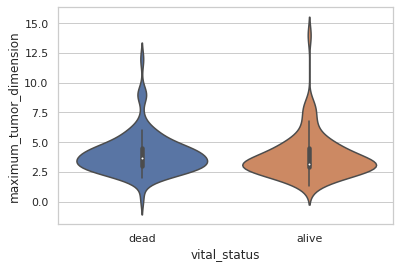

In [0]:
sns.violinplot(x='vital_status', y='maximum_tumor_dimension',data=col_meta)

Most of the patients with bigger tumor size have been dead.

Let's now look at neoplasm_histologic_grade as we want to know how the bad the tumor is based on abnormality of the cancer cells.

In [0]:
col_meta['neoplasm_histologic_grade'].unique()

array(['g3', 'g2', 'g1', 'g4', 'gx'], dtype=object)

We observe that the grading falls into 5 categories. We map encode these categries into integers for smooter processing. This process is called "Integer Encoding"

In [0]:
col_meta['neoplasm_histologic_grade'] = col_meta['neoplasm_histologic_grade'].map({
    'g1':0, 'g2':1, 'g3':2, 'g4':3, 'gx':4
})

In [0]:
col_meta['neoplasm_histologic_grade'].value_counts()

1    98
2    50
0    31
4     2
3     2
Name: neoplasm_histologic_grade, dtype: int64

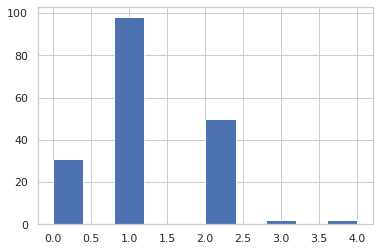

In [0]:
col_meta['neoplasm_histologic_grade'].hist()

We have many cases of grades 2 > 3 > 1 > 4 > gx (respective decresing order)<br>If a grading system for a tumor type is not specified, the following system is generally used:<br>

GX: Grade cannot be assessed (undetermined grade)<br>
G1: Well differentiated (low grade)<br>
G2: Moderately differentiated (intermediate grade)<br>
G3: Poorly differentiated (high grade)<br>
G4: Undifferentiated (high grade)<br>


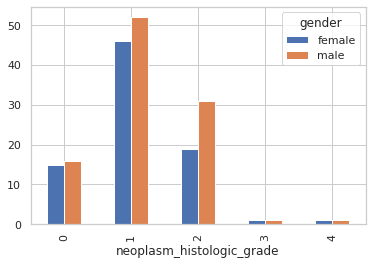

In [0]:
x = pd.crosstab(index=col_meta['neoplasm_histologic_grade'], columns=col_meta['gender'])
x.plot.bar()


So we can see that no matter what grade of tumor it is,  Males are affected more than females.

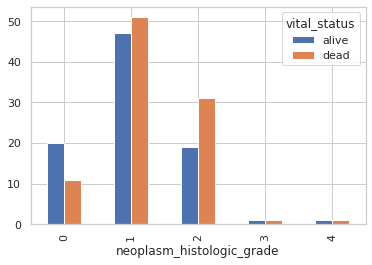

In [0]:
x = pd.crosstab(index=col_meta['neoplasm_histologic_grade'], columns=col_meta['vital_status'])
x.plot.bar()

Interestingly even this plot looks similar to the above tumor grade vs gender. On an average, most of the cases in any tumor grade result in death.

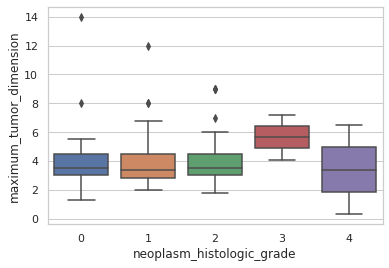

In [0]:
sns.boxplot(x='neoplasm_histologic_grade', y='maximum_tumor_dimension', data=col_meta)

Well, the average tumor dimensions for most of the tumor grades remains the same but then the tumor dimension for grade 4 seems very high.

pathologic_stage provides us important information about the stage of cancer. let's start analysing it


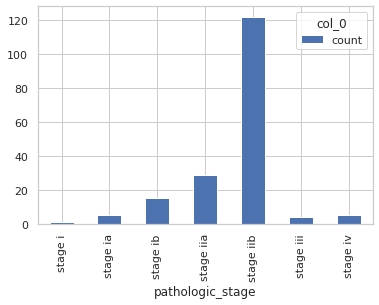

In [0]:
x = pd.crosstab(index=col_meta['pathologic_stage'], columns='count')
x.plot.bar()

It's pretty clear that most of the cases are of stage II B cancer.

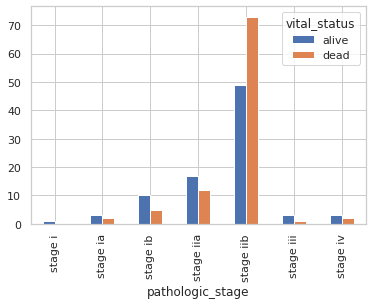

In [0]:
x = pd.crosstab(index=col_meta['pathologic_stage'],columns=col_meta['vital_status'], dropna=True)
x.plot.bar()

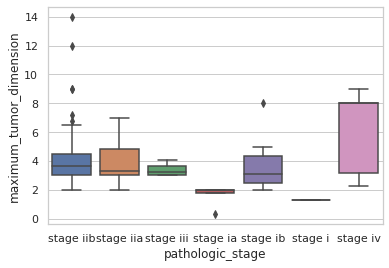

In [0]:
sns.boxplot(x='pathologic_stage', y='maximum_tumor_dimension', data=col_meta)

Apart from stage II B cancer, in every other stage, the cases of alive patients are higher than dead patients. Stage II B cancer has many dead patients when compared to alive patients. This signifies that patients with stage II B are to be more closer to deadth than being alive



pathologic stages are as follow:<br>

* stage 0: Abnormal cells are present but have not spread to nearby tissue.Data set have not this stage because approx all adenocarcinoma_invasion value is True.<br>
* stage i, stage ii,stage iii Cancer is present. The higher the number, the larger the cancer tumor and the more it has spread into nearby tissues.
* stage iv The cancer has spread to distant parts of the body.



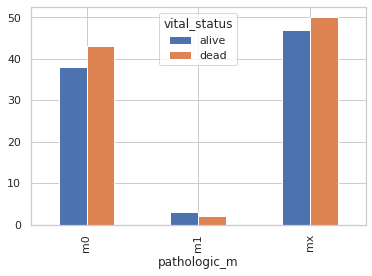

In [0]:
x = pd.crosstab(index=col_meta['pathologic_m'],columns=col_meta['vital_status'], dropna=True)
x.plot.bar()

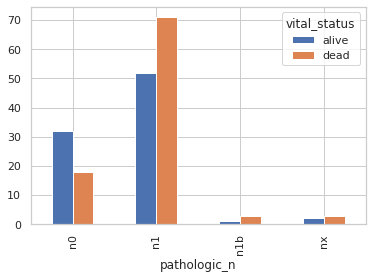

In [0]:
x = pd.crosstab(index=col_meta['pathologic_n'],columns=col_meta['vital_status'], dropna=True)
x.plot.bar()

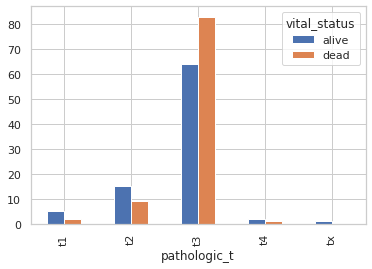

In [0]:
x = pd.crosstab(index=col_meta['pathologic_t'],columns=col_meta['vital_status'], dropna=True)
x.plot.bar()



* Pathologic T ->  The size and extent of the Primary Tumor. <br>
* Pathologic N ->  The number of nearby lymph nodes that have cancer.<br>
* Pathologic M ->  The cancer has metastasized or not.<br>

Majority of patient have pathologic t3 and pathologic n1 stages.



Below is the analaysis of Surgeries performed:

In [0]:
col_meta['surgery_performed_type'].value_counts()

whipple                          139
distal pancreatectomy             25
other method (please specify)     13
total pancreatectomy               4
Name: surgery_performed_type, dtype: int64

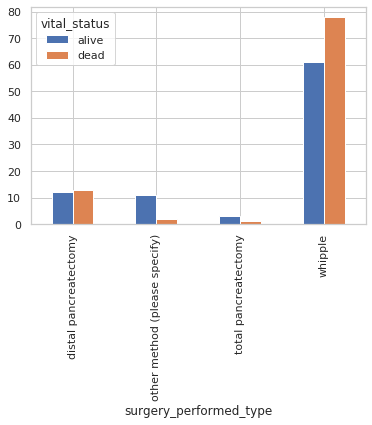

In [0]:
x = pd.crosstab(index=col_meta['surgery_performed_type'], columns=col_meta['vital_status'])
x.plot.bar()

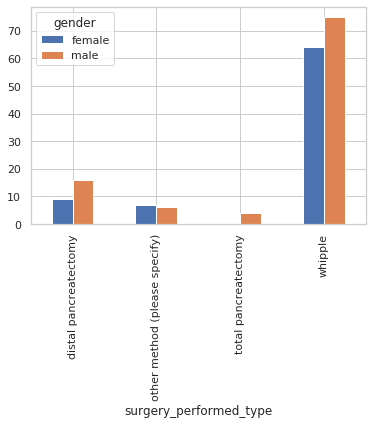

In [0]:
x = pd.crosstab(index=col_meta['surgery_performed_type'], columns=col_meta['gender'])
x.plot.bar()

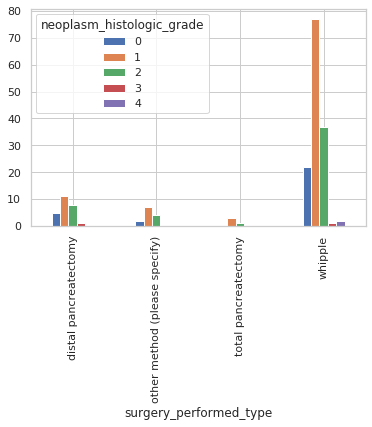

In [0]:
x = pd.crosstab(index=col_meta['surgery_performed_type'], columns=col_meta['neoplasm_histologic_grade'])
x.plot.bar()

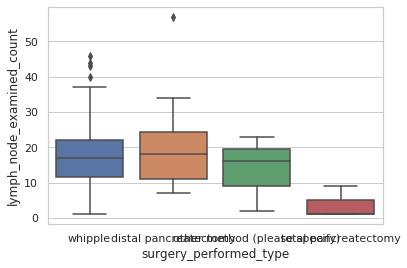

In [0]:
sns.boxplot(x='surgery_performed_type', y='lymph_node_examined_count',data=col_meta)

Well we can see that whipple surgery was conducted in many cases.

In [0]:
print(len(data_im.columns.unique()))
print(len(col_meta.index.unique()))

183
183


##Processing the Gene sequence data:<br>
1. List out the important attributes required for analaysis from col_meta and later merge it with our imputed dataset for complete analysis of gene-expression<br>
2. Fix a target variable. In our case it's the 'sample_type' attribute<br>
3. Reindex the col_meta data and new imputed data w.r.t 'participant_id' and transpose it. So that our rows are patient ids and the columns are genes.<br>


In [68]:
col_to_merge = ['sample_type', 'mRNAseq_cluster', 'gender', 'adenocarcinoma_invasion', 'surgery_performed_type' ,'neoplasm_histologic_grade', 'maximum_tumor_dimension' ,'age_at_initial_pathologic_diagnosis', 'vital_status', 'maximum_tumor_dimension', 'pathologic_stage', 'pathologic_m', 'pathologic_n', 'pathologic_t']
participant_id = col_meta['participant_id']
target_variable = col_meta['sample_type']
col_meta = col_meta.set_index('participant_id')
data_im = data_im.rename(columns=participant_id).T
data_im.head()

rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,...,ZP3,ZPBP2,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aab1,7.45,6.4,4.7,-1.000000,7.5,6.400000,14.3,10.6,8.8,1.000000,9.4,-1.000000,10.2,9.2,4.8,10.2,9.6,11.8,-0.347509,8.6,8.9,11.3,8.6,7.5,8.1,10.6,10.0,9.4,4.4,5.8,1.8,7.4,1.000000,7.8,10.4,9.7,1.0,8.1,7.9,9.3,...,7.7,-0.934917,3.9,9.4,9.4,5.5,8.1,4.0,7.2,6.9,9.1,1.5,6.0,8.0,7.3,3.4,8.7,7.1,0.5,6.0,0.5,8.6,7.1,8.8,8.2,8.8,8.1,7.0,8.6,8.1,8.6,6.2,9.0,9.9,0.098404,9.2,12.9,10.1,9.3,5.5
aab4,8.10,5.8,5.7,1.100000,6.8,1.858623,14.0,10.2,5.6,-1.200000,9.1,-0.200000,10.3,5.0,6.3,10.4,9.8,11.4,0.300000,8.4,8.7,11.6,9.0,7.5,8.2,10.2,8.1,9.3,4.9,5.7,6.3,4.9,3.000000,8.5,10.9,9.5,0.8,9.0,6.0,9.7,...,6.6,-0.623276,5.7,9.6,10.2,5.4,7.9,5.0,7.0,6.1,9.8,3.1,6.0,7.6,6.2,3.7,8.5,7.5,-1.2,5.7,0.8,7.9,6.2,9.2,6.9,9.4,8.1,7.5,8.7,8.1,8.8,5.8,8.5,10.0,0.363095,9.3,12.4,9.8,8.9,4.5
aab6,7.20,6.4,3.0,-0.064388,7.3,10.800000,13.1,10.1,0.2,0.200000,9.7,0.578651,9.2,2.8,5.9,9.9,9.8,11.1,2.200000,8.4,8.8,11.4,9.3,6.7,7.3,10.3,7.3,8.4,4.7,6.1,7.4,8.0,1.800000,9.2,10.6,8.0,4.1,7.7,5.7,10.4,...,7.8,-0.766393,3.0,9.5,10.4,4.9,7.8,5.2,6.6,5.4,9.9,2.9,6.3,7.7,6.6,2.4,7.9,6.9,2.0,5.7,0.8,8.2,5.7,8.8,5.3,8.7,7.3,7.0,8.8,8.4,9.1,3.9,8.1,10.0,-0.800000,9.4,13.5,9.8,9.2,4.7
aab8,8.00,5.8,5.1,-0.280894,7.5,4.100000,13.8,8.6,3.2,-0.100000,9.6,-0.100000,9.4,7.7,6.4,10.5,9.2,11.6,-0.100000,8.7,9.1,11.4,9.4,7.7,7.8,10.1,8.3,8.4,5.4,6.6,7.3,7.1,2.617126,9.0,10.0,7.9,5.2,7.6,6.7,10.4,...,6.6,0.982120,0.9,9.7,10.6,5.7,8.0,6.0,7.6,6.5,9.2,0.9,5.9,7.1,6.8,4.0,8.9,7.4,4.2,6.1,2.5,8.0,6.1,9.8,6.3,8.8,8.0,7.4,8.6,8.6,8.9,5.2,8.5,9.7,1.900000,9.4,12.5,9.7,9.3,6.4
aab9,7.65,6.7,4.4,0.100000,7.4,9.300000,14.6,10.1,5.7,0.170324,9.8,1.162987,9.3,7.0,6.5,10.1,9.8,11.2,0.100000,8.4,9.3,11.4,9.4,7.2,8.3,10.3,8.6,9.4,5.9,6.2,6.1,6.0,1.700000,8.7,10.0,9.3,3.3,8.8,7.7,9.2,...,8.1,0.100000,4.9,9.7,9.7,4.8,8.1,5.1,7.3,6.2,10.1,2.4,5.7,7.9,7.0,4.3,8.6,8.0,1.7,6.1,0.1,8.4,7.0,9.9,6.9,8.6,8.0,7.0,8.9,8.2,8.4,5.9,8.6,9.9,0.100000,9.3,13.0,10.1,9.2,4.9


As we can see that the target variable is an categorical data and we can't process it directly. Thus we should employ encoding stratergies to handle categorical data. One such stratergy we apply here is 'Integer Encoding' for categorical data preprocessing.

In [69]:
target_variable.value_counts()

Primary solid Tumor    178
Solid Tissue Normal      4
Metastatic               1
Name: sample_type, dtype: int64

In [0]:
target_variable = target_variable.map({'Primary solid Tumor':0, 'Solid Tissue Normal':1,'Metastatic':2})

Merge the data with the features from col_meta so we get a complete dataset.

In [71]:
for col in col_to_merge:
    data_im[col] = col_meta[col]
data_im.head(2)

rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,...,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,sample_type,mRNAseq_cluster,gender,adenocarcinoma_invasion,surgery_performed_type,neoplasm_histologic_grade,maximum_tumor_dimension,age_at_initial_pathologic_diagnosis,vital_status,pathologic_stage,pathologic_m,pathologic_n,pathologic_t
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aab1,7.45,6.4,4.7,-1.0,7.5,6.400000,14.3,10.6,8.8,1.0,9.4,-1.0,10.2,9.2,4.8,10.2,9.6,11.8,-0.347509,8.6,8.9,11.3,8.6,7.5,8.1,10.6,10.0,9.4,4.4,5.8,1.8,7.4,1.0,7.8,10.4,9.7,1.0,8.1,7.9,9.3,...,8.0,7.3,3.4,8.7,7.1,0.5,6.0,0.5,8.6,7.1,8.8,8.2,8.8,8.1,7.0,8.6,8.1,8.6,6.2,9.0,9.9,0.098404,9.2,12.9,10.1,9.3,5.5,Primary solid Tumor,1.0,male,yes,whipple,g3,4.5,65,dead,stage iib,m0,n1,t3
aab4,8.10,5.8,5.7,1.1,6.8,1.858623,14.0,10.2,5.6,-1.2,9.1,-0.2,10.3,5.0,6.3,10.4,9.8,11.4,0.300000,8.4,8.7,11.6,9.0,7.5,8.2,10.2,8.1,9.3,4.9,5.7,6.3,4.9,3.0,8.5,10.9,9.5,0.8,9.0,6.0,9.7,...,7.6,6.2,3.7,8.5,7.5,-1.2,5.7,0.8,7.9,6.2,9.2,6.9,9.4,8.1,7.5,8.7,8.1,8.8,5.8,8.5,10.0,0.363095,9.3,12.4,9.8,8.9,4.5,Primary solid Tumor,2.0,male,yes,distal pancreatectomy,g2,6.8,48,alive,stage iib,m0,n1,t2


In [72]:
data_im.isnull().sum().sum()

25

Standardization of data. It's a feature scaling step which is very important as it shall help us to train our data faster and makes it converge sooner to the globle optimum. With standardization we acheive a zero mean and a unit variance in our data.

In [0]:
Stdscalar = StandardScaler()

data_std = Stdscalar.fit_transform(data_im.drop(columns=col_to_merge, axis=1))

Principal components analysis (PCA) is an ordination technique used primarily to display patterns in multivariate data. It aims to display the relative positions of data points in fewer dimensions while retaining as much information as possible, and explore relationships between dependent variables

A PCA is commonly used to see if two (or more) groups of samples are represented separately or mixed in the 2D plot. In our case we check if samples from two classes, endocrines and neurocrines, are mixed are not.

Choosing the Right number of Dimensions. Instead of arbitarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions required to add up to sufficiently large portions of variance.

Below we are trying to perform PCA without reducing dimensionality, then compute minimum number of dimensions required to perserve 95% of the variance 

In [74]:
pca = PCA()
pca.fit(data_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95 ) + 1
print('Number of Dimensions required to preserve 95% of the variance of our Gene-Sequence data: {} Dimensions'.format(d))

Number of Dimensions required to preserve 95% of the variance of our Gene-Sequence data: 123 Dimensions


Now that we get the number of dimensions requried to preserve 95% of the variance, we reduce the data to those number of dimensions.

In [0]:
pca = PCA(n_components=d)
data_red = pca.fit_transform(data_std)

Let's plot the Explained variance vs number of dimensions

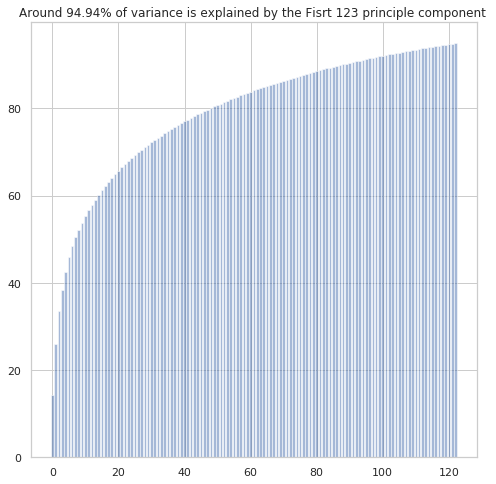

In [76]:
cum_sum = pca.explained_variance_ratio_.cumsum()

explained_var = round(pca.explained_variance_ratio_.sum()*100, 2)

cum_sum = cum_sum*100

fig, ax = plt.subplots(figsize=(8,8))
plt.bar(range(d), cum_sum, label='Cumulative _Sum_of_Explained _Varaince', color = 'b',alpha=0.5)
plt.title(f"Around {explained_var}% of variance is explained by the Fisrt {d} principle component ");


The analysis reveals that 123 principle components are needed to account for 95% of the variance. 

In [77]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
x = ["PC%s" %i for i in range(1,d)]
trace1 = go.Bar(x=x, y=list(var_exp), name="Explained Variance")

trace2 = go.Scatter(x=x, y=cum_var_exp, name="Cumulative Variance")

layout = go.Layout( title='Explained variance', xaxis=dict(title='Principle Components', tickmode='linear'))

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

The above plot helps us understand and visualize the amount of variance preserved by each Principle Component. The first three priniciple components account 33% of the variance and first eight priniciple components account for 50% of the variance. Eventually as the prinicple components increases, the variance preserved by new principle components steadyly decreases.

As the first three prinicple components preserve 33% of the variance, lets project these principle components and visualize the whole data

[]

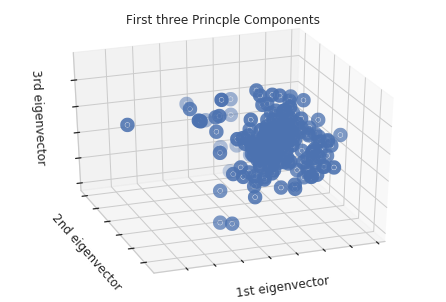

In [78]:
pca_3 = PCA(n_components=3)
data_red_3  = pca_3.fit_transform(data_std)
Y=target_variable


plt.clf()
fig = plt.figure(1, figsize=(10,10 ))

ax = Axes3D(fig, elev=-150, azim=110,)
ax.scatter(data_red_3[:, 0], data_red_3[:, 1], data_red_3[:, 2],cmap=plt.cm.Spectral,linewidths=10)
ax.set_title("First three Princple Components")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])


2D Transformation of above 3D graph is below: <br>

Primary solid Tumor -> RED, <br>
Solid Tissue Normal -> GREEN, <br>
Metastatic -> BLUE<br>

Text(0, 0.5, 'component 2')

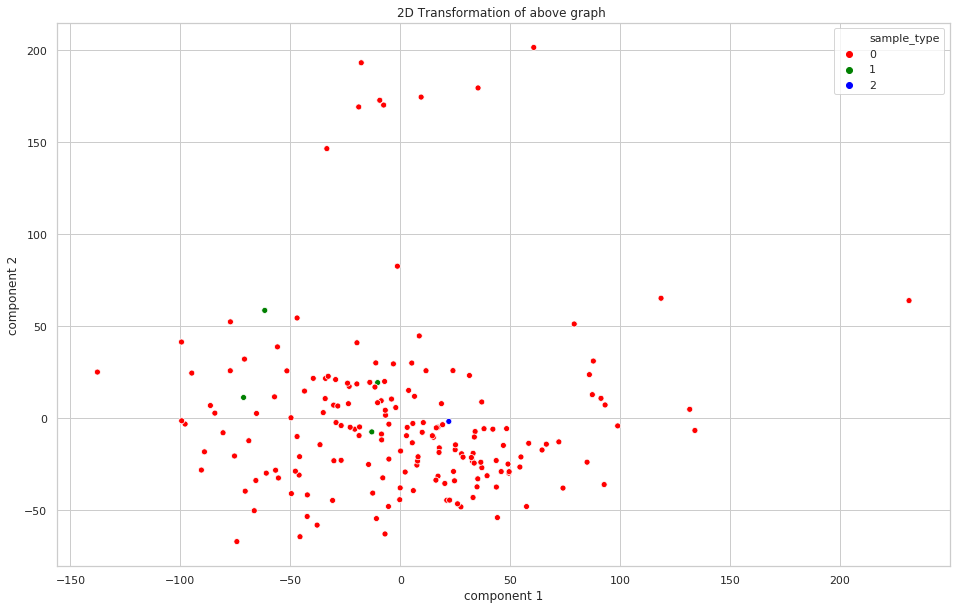

In [79]:
fig = plt.figure(1, figsize=(16,10))
sns.scatterplot(data_red_3[:, 0],  data_red_3[:, 1],hue=target_variable, palette=['red','green','blue'])
plt.title("2D Transformation of above graph ")
plt.xlabel('component 1')
plt.ylabel('component 2')

The neuroendocrine tumors clearly not separable from the endocrine tumors. These samples are very mixed i.e it means (visually!! remember that a PCA is not a real statistical test but an ordination analysis!) that neuroendocrine and endocrine are similar.

Let's look at only endocrine tumor samples and remove the neuroendocrine tumor samples from our imputed dataset

In [80]:
data_im['adenocarcinoma_invasion'].value_counts()

yes    182
no       1
Name: adenocarcinoma_invasion, dtype: int64

In [81]:
data_im_endo = data_im[data_im['adenocarcinoma_invasion'] == 'yes']
data_im_endo.head()

rid,SLC35E2,A1BG,A1CF,A2BP1,A2LD1,A2ML1,A2M,A4GALT,A4GNT,AAA1,AAAS,AACSL,AACS,AADAC,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,...,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,sample_type,mRNAseq_cluster,gender,adenocarcinoma_invasion,surgery_performed_type,neoplasm_histologic_grade,maximum_tumor_dimension,age_at_initial_pathologic_diagnosis,vital_status,pathologic_stage,pathologic_m,pathologic_n,pathologic_t
cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
aab1,7.45,6.4,4.7,-1.000000,7.5,6.400000,14.3,10.6,8.8,1.000000,9.4,-1.000000,10.2,9.2,4.8,10.2,9.6,11.8,-0.347509,8.6,8.9,11.3,8.6,7.5,8.1,10.6,10.0,9.4,4.4,5.8,1.8,7.4,1.000000,7.8,10.4,9.7,1.0,8.1,7.9,9.3,...,8.0,7.3,3.4,8.7,7.1,0.5,6.0,0.5,8.6,7.1,8.8,8.2,8.8,8.1,7.0,8.6,8.1,8.6,6.2,9.0,9.9,0.098404,9.2,12.9,10.1,9.3,5.5,Primary solid Tumor,1.0,male,yes,whipple,g3,4.5,65,dead,stage iib,m0,n1,t3
aab4,8.10,5.8,5.7,1.100000,6.8,1.858623,14.0,10.2,5.6,-1.200000,9.1,-0.200000,10.3,5.0,6.3,10.4,9.8,11.4,0.300000,8.4,8.7,11.6,9.0,7.5,8.2,10.2,8.1,9.3,4.9,5.7,6.3,4.9,3.000000,8.5,10.9,9.5,0.8,9.0,6.0,9.7,...,7.6,6.2,3.7,8.5,7.5,-1.2,5.7,0.8,7.9,6.2,9.2,6.9,9.4,8.1,7.5,8.7,8.1,8.8,5.8,8.5,10.0,0.363095,9.3,12.4,9.8,8.9,4.5,Primary solid Tumor,2.0,male,yes,distal pancreatectomy,g2,6.8,48,alive,stage iib,m0,n1,t2
aab6,7.20,6.4,3.0,-0.064388,7.3,10.800000,13.1,10.1,0.2,0.200000,9.7,0.578651,9.2,2.8,5.9,9.9,9.8,11.1,2.200000,8.4,8.8,11.4,9.3,6.7,7.3,10.3,7.3,8.4,4.7,6.1,7.4,8.0,1.800000,9.2,10.6,8.0,4.1,7.7,5.7,10.4,...,7.7,6.6,2.4,7.9,6.9,2.0,5.7,0.8,8.2,5.7,8.8,5.3,8.7,7.3,7.0,8.8,8.4,9.1,3.9,8.1,10.0,-0.800000,9.4,13.5,9.8,9.2,4.7,Primary solid Tumor,3.0,male,yes,distal pancreatectomy,g2,5.0,75,dead,stage iia,m0,n0,t3
aab8,8.00,5.8,5.1,-0.280894,7.5,4.100000,13.8,8.6,3.2,-0.100000,9.6,-0.100000,9.4,7.7,6.4,10.5,9.2,11.6,-0.100000,8.7,9.1,11.4,9.4,7.7,7.8,10.1,8.3,8.4,5.4,6.6,7.3,7.1,2.617126,9.0,10.0,7.9,5.2,7.6,6.7,10.4,...,7.1,6.8,4.0,8.9,7.4,4.2,6.1,2.5,8.0,6.1,9.8,6.3,8.8,8.0,7.4,8.6,8.6,8.9,5.2,8.5,9.7,1.900000,9.4,12.5,9.7,9.3,6.4,Primary solid Tumor,1.0,male,yes,whipple,g3,3.5,71,alive,stage iib,m0,n1,t3
aab9,7.65,6.7,4.4,0.100000,7.4,9.300000,14.6,10.1,5.7,0.170324,9.8,1.162987,9.3,7.0,6.5,10.1,9.8,11.2,0.100000,8.4,9.3,11.4,9.4,7.2,8.3,10.3,8.6,9.4,5.9,6.2,6.1,6.0,1.700000,8.7,10.0,9.3,3.3,8.8,7.7,9.2,...,7.9,7.0,4.3,8.6,8.0,1.7,6.1,0.1,8.4,7.0,9.9,6.9,8.6,8.0,7.0,8.9,8.2,8.4,5.9,8.6,9.9,0.100000,9.3,13.0,10.1,9.2,4.9,Primary solid Tumor,4.0,female,yes,whipple,g1,4.0,70,dead,stage iib,m0,n1,t3


Interferons (IFNs) are a group of signaling proteins made and released by host cells in response to
the presence of several pathogens, such as viruses, bacteria, parasites, and also tumor cells. Type I
interferons (IFNs) are a large subgroup of interferon proteins that help regulate the activity of the
immune system.<br> The genes responsible for type 1 Interferons is called Type 1 IFN signature and
consists of a set of 25 genes in homo sapiens.<br>
Let's read these 25 IFN signatures


In [82]:
ifn = pd.read_csv('type1_IFN.txt', sep=" ", header=None)
ifn.columns = ['member']
ifn.head()

,member
0,IFIT1
1,IFI44
2,IFIT3
3,MX2
4,OAS1


In [0]:
ifn_data = data_im_endo[ifn['member'].to_list()]

In [84]:
ifn_data.shape

(182, 25)

Plotting the gene expression values for these genes for pancreatic adenocarcinoma

In [0]:
Stdscalar = StandardScaler()

ifn_data_std = Stdscalar.fit_transform(ifn_data)

In [86]:
pca = PCA()
pca.fit(ifn_data_std)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95 ) + 1
print('Number of Dimensions required to preserve 95% of the variance of our Gene-Sequence data: {} Dimensions'.format(d))

Number of Dimensions required to preserve 95% of the variance of our Gene-Sequence data: 14 Dimensions


In [0]:
pca = PCA(n_components=d)
ifn_data_red = pca.fit_transform(ifn_data_std)

Text(0, 0.5, 'component 2')

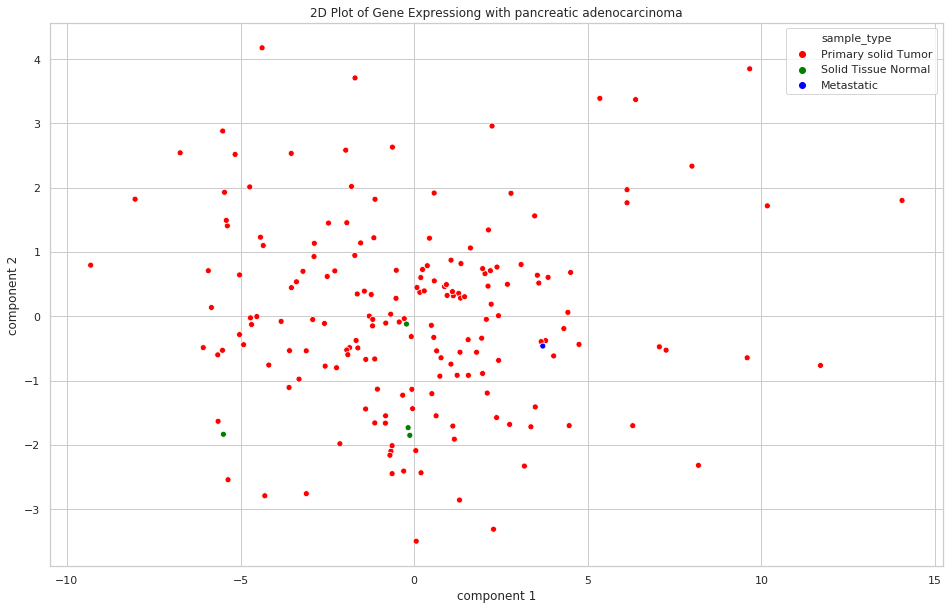

In [88]:
fig = plt.figure(1, figsize=(16,10))
sns.scatterplot(ifn_data_red[:, 0],  ifn_data_red[:, 1],hue=data_im_endo['sample_type'], palette=['red','green','blue'])
plt.title("2D Plot of Gene Expressiong with pancreatic adenocarcinoma")
plt.xlabel('component 1')
plt.ylabel('component 2')

Gene Set Variation analysis is a technique for signature summaries from a gene expression dataset.

We have our main gene expression data which is the 25 gene IFN signature
as the gene set subsetted pancreatic cancer data

In [90]:
expression_df = ifn_data.T
expression_df.head()

cid,aab1,aab4,aab6,aab8,aab9,aaba,aabe,aabf,aabh,aabi,aabk,aabo,aabp,aabr,aabt,aabu,aabv,aaqa,aaqe,aaqi,aaqj,aaql,aaqm,a9i5,a9i7,a9i9,a9ib,a9ic,a9ih,a9ij,a9il,a9in,a9io,a9ir,a9is,a9iu,a9iv,a9ix,a9iz,a9j0,...,aauo,aaup,aauq,aaur,aaus,aaut,aauu,aauv,aauw,a7w4,a7sx,a8f3,a9q5,a5n4,a75w,a5re,a5qy,aa2a,a7b8,aa9m,aaas,a8rm,a8ro,a8rp,a774,a776,a779,a77e,a77g,a77j,aauh,aaui,aaul,a8t3,a8t5,a89d,a89d,a8sy,a8lh,aapl
rid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
IFIT1,9.5,10.5,12.2,10.7,8.6,6.7,9.0,11.4,8.5,7.2,10.6,9.4,8.0,8.8,8.2,7.6,8.4,7.3,11.4,10.2,8.1,8.7,6.8,8.6,9.6,8.6,9.4,8.3,9.6,9.4,8.5,8.1,8.5,8.3,7.8,10.1,7.1,9.3,7.4,7.4,...,12.5,8.7,11.3,7.1,11.1,9.6,10.2,8.3,10.1,8.9,9.9,9.5,9.5,9.1,9.2,11.0,8.2,7.7,9.0,8.8,9.7,5.7,9.0,8.3,9.7,5.3,8.3,10.4,9.7,7.5,8.3,7.6,9.6,8.7,9.4,8.4,9.5,10.4,11.1,10.2
IFI44,9.4,11.1,11.2,10.6,8.8,8.4,9.0,11.1,8.6,7.9,10.4,9.4,9.7,9.8,8.7,9.1,8.6,7.8,11.0,9.9,8.5,8.8,5.9,7.1,9.2,8.4,9.5,8.9,10.2,6.9,6.8,7.6,6.5,5.6,4.1,9.9,6.5,9.2,8.1,8.9,...,12.3,9.6,11.0,8.6,10.7,9.2,10.7,9.1,10.3,8.3,10.4,9.3,9.0,10.0,9.4,11.0,8.9,9.2,9.5,8.8,9.7,8.2,9.7,9.3,10.0,6.9,8.9,10.9,9.6,8.8,8.3,8.3,9.8,10.0,9.3,8.9,9.3,10.6,10.8,10.9
IFIT3,10.0,10.8,11.6,10.3,9.0,7.8,9.4,11.5,9.1,9.1,10.2,9.2,9.5,9.5,9.0,8.2,8.9,8.5,11.1,10.1,9.0,9.2,8.1,7.3,10.0,9.2,9.8,8.8,10.0,9.0,7.6,8.1,7.1,6.4,6.6,10.1,7.4,9.4,8.5,8.2,...,12.2,9.3,11.1,8.0,11.3,10.1,10.0,9.0,10.2,9.0,9.2,9.2,9.6,10.1,9.7,10.9,8.6,8.4,9.6,9.1,10.2,8.0,9.4,9.4,10.4,7.9,9.0,10.1,9.8,7.9,7.9,8.3,9.8,9.8,9.6,9.1,9.6,10.5,10.7,10.2
MX2,9.8,10.7,11.0,10.8,8.3,9.2,9.9,11.1,9.2,9.2,9.1,8.7,8.2,8.8,8.9,9.6,8.6,10.0,11.0,10.2,8.5,8.6,6.9,8.5,10.1,8.2,9.7,10.1,10.4,5.4,7.5,7.5,6.7,8.3,4.9,10.6,6.4,9.5,7.5,8.5,...,11.0,9.7,10.8,9.5,11.0,8.8,11.0,9.0,9.9,9.4,11.1,9.8,8.0,9.9,9.8,11.6,10.3,10.2,9.2,8.9,9.3,9.2,10.0,8.8,9.7,9.3,9.6,10.9,10.5,9.5,9.3,9.2,10.0,9.2,9.7,9.3,10.0,11.4,11.5,10.9
OAS1,11.7,11.0,11.3,10.5,9.2,10.6,10.5,11.4,8.9,7.5,11.2,11.1,8.6,9.4,9.3,10.3,9.1,10.2,12.1,11.0,9.6,9.6,6.9,8.3,10.5,9.8,11.2,9.4,11.1,9.2,7.7,7.3,8.0,5.1,7.2,10.1,8.0,9.5,10.1,9.2,...,12.6,10.6,11.9,9.1,11.1,10.1,11.2,8.7,10.1,9.8,10.3,9.7,10.5,10.5,11.7,12.8,9.8,10.4,10.3,9.0,9.2,9.4,11.1,9.4,10.0,10.8,10.7,10.7,11.0,8.3,8.3,9.5,10.8,8.9,9.5,10.5,10.9,11.1,11.9,10.7


In [0]:
expression_df.to_csv('gene_expression.csv')

In [0]:
t_sne = TSNE(2)
XV = t_sne.fit_transform(ifn_data_std.T)

In [0]:
df = pd.DataFrame(XV).rename(columns={0:'x',1:'y'})

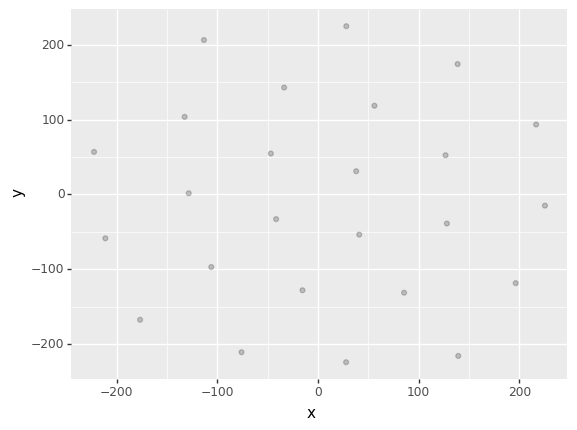

<ggplot: (8794828677745)>

In [94]:
(ggplot(df,aes(x='x',y='y'))
 + geom_point(alpha=0.2)
)

Let's look at some of the ECDFs of our gene samples. The ECDF is an unbiased and maximum likelihood estimator of the theoretical CDF of the process generating the data. An ECDF is an estimator of the Cumulative Distribution Function. The ECDF essentially allows you to plot a feature of your data in order from least to greatest and see the whole feature as if is distributed across the data set.

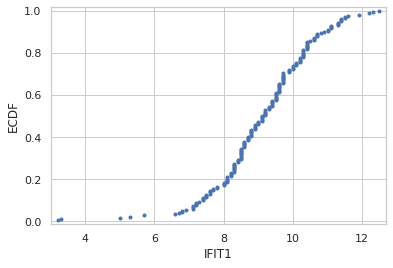

In [0]:
x = expression_df[:1].values[0]
x = np.sort(x)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x,y, marker='.', linestyle='none')
_ = plt.xlabel('IFIT1')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

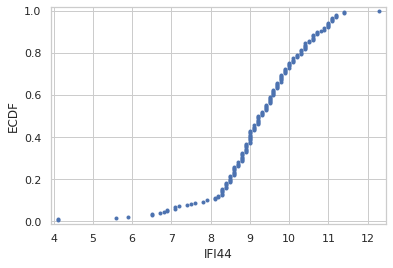

In [0]:
x = expression_df[1:2].values[0]
x = np.sort(x)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x,y, marker='.', linestyle='none')
_ = plt.xlabel('IFI44')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

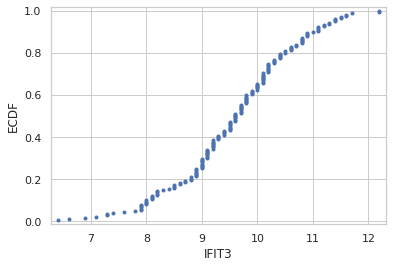

In [0]:
x = expression_df[2:3].values[0]
x = np.sort(x)
y = np.arange(1, len(x)+1) / len(x)
_ = plt.plot(x,y, marker='.', linestyle='none')
_ = plt.xlabel('IFIT3')
_ = plt.ylabel('ECDF')
_ = plt.margins(0.02)

In [98]:
genesets_df = gmt_to_dataframe('genesets_1.gmt')
genesets_df.head()

,name,description,member
0,AGUIRRE_PANCREATIC_CANCER_COPY_NUMBER_DN,> Down-regulated genes whose expression correl...,ACVR1B
1,AGUIRRE_PANCREATIC_CANCER_COPY_NUMBER_DN,> Down-regulated genes whose expression correl...,ADNP2
2,AGUIRRE_PANCREATIC_CANCER_COPY_NUMBER_DN,> Down-regulated genes whose expression correl...,AHI1
3,AGUIRRE_PANCREATIC_CANCER_COPY_NUMBER_DN,> Down-regulated genes whose expression correl...,AK2
4,AGUIRRE_PANCREATIC_CANCER_COPY_NUMBER_DN,> Down-regulated genes whose expression correl...,ALPL


In [0]:
%matplotlib inline
import gseapy 

In [134]:
gene_list = pd.read_csv("/content/type1_IFN.txt",header=None, sep="\t")
gene_list.head()

,0
0,IFIT1
1,IFI44
2,IFIT3
3,MX2
4,OAS1


In [136]:
names = gseapy.get_library_name() # default: Human
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_down']

In [0]:
# gene_sets = list(ifn['member'])
gene_sets="/content/c2.cp.v4.0.symbols.gmt",

In [0]:
enr = gseapy.enrichr(gene_list="/content/type1_IFN.txt",
                 gene_sets=['KEGG_2016','KEGG_2013'],
                 description='test_name',
                 outdir='test/enrichr_kegg',
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [139]:
enr.results.head(5)

,Adjusted P-value,Combined Score,Gene_set,Genes,Odds Ratio,Old Adjusted P-value,Old P-value,Overlap,P-value,Term
0,1.296822e-10,1170.354113,KEGG_2016,IFIH1;CXCL10;OAS1;STAT1;OAS2;STAT2;OAS3;MX1;IRF9,41.142857,0,0,9/175,4.426013e-13,Influenza A Homo sapiens hsa05164
1,4.452367e-10,1276.123456,KEGG_2016,OAS1;STAT1;OAS2;STAT2;IRF1;OAS3;IFIT1;IRF9,48.120301,0,0,8/133,3.039158e-12,Hepatitis C Homo sapiens hsa05160
2,3.557175e-10,1239.456209,KEGG_2016,IFIH1;OAS1;STAT1;OAS2;STAT2;OAS3;MX1;IRF9,47.058824,0,0,8/136,3.642159e-12,Measles Homo sapiens hsa05162
3,3.188179e-09,825.347254,KEGG_2016,IFIH1;OAS1;STAT1;OAS2;STAT2;OAS3;IFIT1;IRF9,34.594595,0,0,8/185,4.352463e-11,Herpes simplex infection Homo sapiens hsa05168
4,1.206728e-03,261.589761,KEGG_2016,SOCS1;STAT1;STAT2;IRF9,24.242424,0,0,4/132,2.059262e-05,Osteoclast differentiation Homo sapiens hsa04380


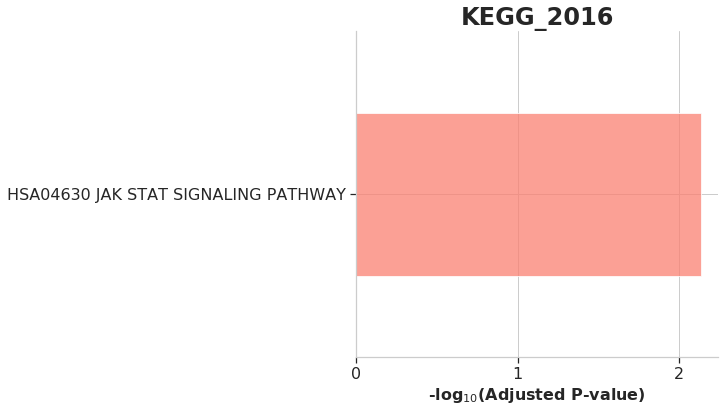

In [140]:
from gseapy.plot import barplot, dotplot

# to save your figure, make sure that ``ofname`` is not None
barplot(enr.res2d,title='KEGG_2016',)

Even after trying so much could'nt make the GSVA algorithm work on the gene expression data set. Tried R (docker) and python implementations but still the 'pathways.csv' error exists. Not having the CSV file for the pathway analysis was the major issue. 

Anyways, Let's move to conclusion

# Final Conclusion of the analysis:<br>
The gene expression data what we have is definatly hard to work around with. With clear visualizations we could see that saperating endocrine data from the neuroendocrine data is not possible as the 2D - PCA plot is very mixed. The plot of gene-expression data shows that our data points are much uniformly spread over the 2D plan which means there is no much correlation seen between the points.
